# Spark Installation

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

# Imports

**Libraries Import**



In [ ]:
import requests
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
%matplotlib inline
 
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model, Input
from keras.layers import Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.utils.vis_utils import plot_model

**Google Drive Import**

In [ ]:
#Drive Folder 

from google.colab import drive
drive.mount('/content/drive')

'''BIG DATA COMPUTING PROJECT DIRECTORY - Lorenzo'''
path = '/content/drive/My Drive/Big Data Computing'
!ln -s /content/drive/My\ Drive/Big\ Data\ Computing /mydrive

# Directory - Professor
# path = ''
# !ln -s ...

Mounted at /content/drive


# Paths

Define all the file paths on Google Drive used in this Notebook 

In [ ]:
dataset_path = path + "/ATP Dataset" 
file_path = dataset_path + '/ATP.csv'
file2_path = dataset_path + '/ATP_final.csv'
file3_path = dataset_path + '/ATP_data_new.csv'
file4_path = dataset_path + '/ATP_final_stats.csv'
file5_path = dataset_path + '/ATP_matches_20-21-22.csv'
file6_path = dataset_path + '/ATP_matches_20-21-22_new.csv'
file7_path = dataset_path + '/ATP_no_data.csv'

# Utility

Functions recurrently used in the Notebook:
- **check_null**: takes a dataframe and returns the number of NULL values for each column.
- **check_null_features**: takes a dataframe, the numerical features and the categorical features and returns the number of NULL values for each column in the dataframe that is also a feature of our model.
- **swap_values**: given a row of a dataframe and two columns of the same dataframe, it swaps the values of the two columns for that row.
- **calc_ranking_prediction**: given a row of a dataframe, this function predicts the outcome of the tennis match solely on the position of the two players in the ATP rankings.
- **evaluate_model**: evaluates the trained model based on the AreaUnderROC or the AreaUnderPR metrics.

In [ ]:
def check_null(sp_data):
  for c in sp_data.columns:
    #print("N. of None values of column `{:s}` = {:d}".format(c, sp_data.where(col(c)=='None').count()))
    print("N. of Null values of column `{:s}` = {:d}".format(c, sp_data.where(col(c).isNull()).count()))

def check_null_features(sp_data, num_features, cat_features):
  for c in sp_data.columns:
    if c in num_features or c in cat_features:   
      #print("N. of None values of column `{:s}` = {:d}".format(c, sp_data.where(col(c)=='None').count()))
      print("N. of Null values of column `{:s}` = {:d}".format(c, sp_data.where(col(c).isNull()).count()))

def swap_values(row, par1, par2):
  tmp = row[par1]
  row[par1] = row[par2]
  row[par2] = tmp
  return row

#Check the accuracy by ranking
def calc_ranking_prediction(pd_dataframe):
  count = 0
  for index, row in pd_dataframe.iterrows():
      if row.p1_rank < row.p2_rank and row.p1_win == 1: 
        count += 1
      if row.p1_rank > row.p2_rank and row.p1_win == 0:
        count += 1 
  
  return count

def evaluate_model(predictions, metric):

    evaluator = BinaryClassificationEvaluator(metricName=metric)
    return evaluator.evaluate(predictions)

# Creation of the Final Dataset

In this section, the dataset of all the ATP matches from 1968 to 2019, downloaded at https://www.kaggle.com/sijovm/atpdata, is loaded from *file_path*. After the changes, the modified dataset is saved in the *file2_path*. This section is thought to be run **ONLY ONCE**: in fact, the .csv file at *file2_path* now contains the modified dataset that we will use in the next sections.

In [ ]:
data = spark.read.csv(file_path, sep=',', header=True, inferSchema=True)
data2 = spark.read.csv(file2_path, sep=',', header=True, inferSchema=True)

Modifications:
- Drop all the data that is not useful and the data that cannot be
used in order to do a prediction
- Rename the columns with the caption '*loser*' or '*winner*' to the caption '*p1*' and '*p2*' (player1, player2) 
- Add the '*p1_win*' parameter, our target variable: this parameter is equal to 0 when *p1* loses the match and 1 when *p1* wins
- Drop the entries where the *ranking* of one of the two players is not present

In [ ]:
#Eliminate the data that I won't need

data = data.drop('draw_size', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'loser_ioc', 'loser_entry', 'l_ace', 'l_bpFaced', 'l_bpSaved', 'l_df', 
                 'l_svpt', 'match_num', 'minutes', 'score', 'tourney_id', 'tourney_name', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 
                 'w_ace', 'w_bpFaced', 'w_bpSaved', 'w_df', 'w_svpt', 'winner_entry', 'winner_ioc')

#Rename the columns
data = data.withColumnRenamed("loser_age", "p1_age")
data = data.withColumnRenamed("loser_ht", "p1_ht")
data = data.withColumnRenamed("loser_hand", "p1_hand")
data = data.withColumnRenamed("loser_id", "p1_id")
data = data.withColumnRenamed("loser_name", "p1_name")
data = data.withColumnRenamed("loser_rank", "p1_rank")
data = data.withColumnRenamed("loser_rank_points", "p1_rank_points")
data = data.withColumnRenamed("loser_seed", "p1_seed")

data = data.withColumnRenamed("winner_age", "p2_age")
data = data.withColumnRenamed("winner_ht", "p2_ht")
data = data.withColumnRenamed("winner_hand", "p2_hand")
data = data.withColumnRenamed("winner_id", "p2_id")
data = data.withColumnRenamed("winner_name", "p2_name")
data = data.withColumnRenamed("winner_rank", "p2_rank")
data = data.withColumnRenamed("winner_rank_points", "p2_rank_points")
data = data.withColumnRenamed("winner_seed", "p2_seed")

#p1_win == 0 means that p1 loses the match
data = data.withColumn("p1_win", lit(0))

data = data.dropna(subset=['p1_rank', 'p2_rank'])

data.show(5, truncate=False)

print("The shape of the dataset is {:d} rows by {:d} columns".format(data.count(), len(data.columns)))

+-------+------+-------+-----+------+------------------+-------+--------------+-------+-----+-------+------------+-------------+------+-------+-----+------+-------------+-------+--------------+-------+------+
|best_of|p1_age|p1_hand|p1_ht|p1_id |p1_name           |p1_rank|p1_rank_points|p1_seed|round|surface|tourney_date|tourney_level|p2_age|p2_hand|p2_ht|p2_id |p2_name      |p2_rank|p2_rank_points|p2_seed|p1_win|
+-------+------+-------+-----+------+------------------+-------+--------------+-------+-----+-------+------------+-------------+------+-------+-----+------+-------------+-------+--------------+-------+------+
|5      |23.97 |R      |180.0|100185|Patrick Proisy    |23.0   |null          |null   |R128 |Grass  |19730829    |G            |26.71 |R      |193.0|100126|Stan Smith   |3.0    |null          |1.0    |0     |
|5      |26.27 |R      |null |100137|Han Jurgen Pohmann|30.0   |null          |null   |R128 |Grass  |19730829    |G            |21.87 |L      |183.0|100255|Roscoe T

**Count missing values**:
For each column, we count how many NULL values are present


In [ ]:
check_null(data)

N. of Null values of column `best_of` = 0
N. of Null values of column `p1_age` = 1141
N. of Null values of column `p1_hand` = 5
N. of Null values of column `p1_ht` = 16404
N. of Null values of column `p1_id` = 0
N. of Null values of column `p1_name` = 0
N. of Null values of column `p1_rank` = 0
N. of Null values of column `p1_rank_points` = 51560
N. of Null values of column `p1_seed` = 113327
N. of Null values of column `round` = 0
N. of Null values of column `surface` = 779
N. of Null values of column `tourney_date` = 0
N. of Null values of column `tourney_level` = 0
N. of Null values of column `p2_age` = 332
N. of Null values of column `p2_hand` = 4
N. of Null values of column `p2_ht` = 9257
N. of Null values of column `p2_id` = 0
N. of Null values of column `p2_name` = 0
N. of Null values of column `p2_rank` = 0
N. of Null values of column `p2_rank_points` = 51563
N. of Null values of column `p2_seed` = 84459
N. of Null values of column `p1_win` = 0


**Pandas Dataframe Transfer**

Create the Pandas Dataframe from the Spark Dataframe of the ATP matches. This step is needed since some modifications that we need to perform on the dataset are much more easily done using a Pandas Dataframe. After that, we will riconvert it into a Spark Dataframe in order to make the application of our Machine Learning models possible.

In [ ]:
pd_data = data.toPandas()
print(pd_data)

#The .csv file at file2_path is initially empty
pd2_data = pd.read_csv(file2_path)

        best_of  p1_age p1_hand  ...  p2_rank_points  p2_seed p1_win
0             5   23.97       R  ...             NaN      1.0      0
1             5   26.27       R  ...             NaN      NaN      0
2             5   29.82       R  ...             NaN      NaN      0
3             5   22.51       R  ...             NaN     13.0      0
4             5   29.23       R  ...             NaN      NaN      0
...         ...     ...     ...  ...             ...      ...    ...
144115        3   31.78       R  ...           620.0      NaN      0
144116        3   25.69       R  ...           527.0      NaN      0
144117        3   23.73       R  ...           975.0      3.0      0
144118        3   20.18       R  ...           620.0      NaN      0
144119        3   22.74       R  ...           975.0      3.0      0

[144120 rows x 22 columns]


## Dataset Modifications

*Run time -- about 3 hours*

The initial dataset that we downloaded had the two players named as *loser* and *winner*. In order for the outcome of the match to be an unknown and in order to create a balanced dataset on the newly target parameter '*p1_win*', I performed these actions:
- Swap all the information regarding the players (p1 becomes p2 and viceversa) for HALF of the entries.
- Change the '*p1_win*' parameter from 0 to 1 (meaning that p1 wins the game) for the same HALF of the entries.

In [ ]:
already_done = True

if len(pd2_data) == 0:
  already_done = False
  for index, row in pd_data.iterrows():
    if index % 10000 == 0:
      print("Index: ", index)
    if index % 2 == 0:
      row = swap_values(row, 'p1_age', 'p2_age')
      row = swap_values(row, 'p1_hand', 'p2_hand')
      row = swap_values(row, 'p1_ht', 'p2_ht')
      row = swap_values(row, 'p1_id', 'p2_id')
      row = swap_values(row, 'p1_name', 'p2_name')
      row = swap_values(row, 'p1_rank', 'p2_rank')
      row = swap_values(row, 'p1_rank_points', 'p2_rank_points')
      row = swap_values(row, 'p1_seed', 'p2_seed')
      row['p1_win'] = 1
      pd2_data = pd2_data.append(row)
    else:
      pd2_data = pd2_data.append(row)

if already_done:
  print("The process of creation of the modified dataset has already been done.")

The process of creation of the modified dataset has already been done.


To save the new dataset:
- Transform the newly created DataFrame in a *.csv* file
- Upload it into Google Drive

In [ ]:
if already_done == False:
  csv_medium = pd2_data.to_csv(file2_path)

# Loading of the newly created Dataset


In [ ]:
#Spark DataFrame
sp_data = spark.read.csv(file2_path, sep=',', header=True, inferSchema=True)
sp_data.show(10, truncate=False)

#Transformation to Pandas DataFrame
pd_data = sp_data.toPandas()

+---+-------+------+-------+-----+------+------------------+-------+--------------+-------+-----+-------+------------+-------------+------+-------+-----+------+----------------+-------+--------------+-------+------+
|_c0|best_of|p1_age|p1_hand|p1_ht|p1_id |p1_name           |p1_rank|p1_rank_points|p1_seed|round|surface|tourney_date|tourney_level|p2_age|p2_hand|p2_ht|p2_id |p2_name         |p2_rank|p2_rank_points|p2_seed|p1_win|
+---+-------+------+-------+-----+------+------------------+-------+--------------+-------+-----+-------+------------+-------------+------+-------+-----+------+----------------+-------+--------------+-------+------+
|0  |5      |26.71 |R      |193.0|100126|Stan Smith        |3.0    |null          |1.0    |R128 |Grass  |19730829    |G            |23.97 |R      |180.0|100185|Patrick Proisy  |23.0   |null          |null   |1     |
|1  |5      |26.27 |R      |null |100137|Han Jurgen Pohmann|30.0   |null          |null   |R128 |Grass  |19730829    |G            |21.8

**Count missing values**

In [ ]:
check_null(sp_data)

N. of Null values of column `_c0` = 0
N. of Null values of column `best_of` = 0
N. of Null values of column `p1_age` = 744
N. of Null values of column `p1_hand` = 7
N. of Null values of column `p1_ht` = 12792
N. of Null values of column `p1_id` = 0
N. of Null values of column `p1_name` = 0
N. of Null values of column `p1_rank` = 0
N. of Null values of column `p1_rank_points` = 51562
N. of Null values of column `p1_seed` = 99001
N. of Null values of column `round` = 0
N. of Null values of column `surface` = 779
N. of Null values of column `tourney_date` = 0
N. of Null values of column `tourney_level` = 0
N. of Null values of column `p2_age` = 729
N. of Null values of column `p2_hand` = 2
N. of Null values of column `p2_ht` = 12869
N. of Null values of column `p2_id` = 0
N. of Null values of column `p2_name` = 0
N. of Null values of column `p2_rank` = 0
N. of Null values of column `p2_rank_points` = 51561
N. of Null values of column `p2_seed` = 98785
N. of Null values of column `p1_win` 

## Dataset Preprocessing
Many steps needed in order to make our dataset **USABLE** by the models:
 

1. Handle the *seed* parameters in the dataset: since different tournaments can have different number of seeds, we must find a compromise to identify the Unseeded players. Idea: fixed seed at 45, since the Max Seed is usually 32.
2. Drop the *Ranking Points* columns, since in many cases we don't have ranking points and also because the ranking system changed many times along the years, making it non-homogeneous.
3. Drop entries where categorical data can't be subsituted by the average.
4. Substitute the Mean value to the NULL entries in the case of the *Age* and *Height* of players.
5. Eliminate the entries where *Surface* is None.



In [ ]:
#1)
sp_data = sp_data.na.fill(45, subset=['p1_seed', 'p2_seed'])

#2)
sp_data = sp_data.drop('p1_rank_points', 'p2_rank_points')
sp_data = sp_data.drop('_c0')

#3)
sp_data = sp_data.dropna(subset='p1_hand')
sp_data = sp_data.dropna(subset='surface')
sp_data = sp_data.dropna(subset='p2_hand')

#4)
age_mean = (pd_data['p1_age'].mean() + pd_data['p2_age'].mean())/2
height_mean = (pd_data['p1_ht'].mean() + pd_data['p2_ht'].mean())/2
print("Age mean of players: ", age_mean)
print("Height mean of players:  {:f} cm".format(height_mean))

sp_data = sp_data.na.fill(age_mean, subset=['p1_age', 'p2_age'])
sp_data = sp_data.na.fill(height_mean, subset=['p1_ht', 'p2_ht'])

#5)
sp_data = sp_data.filter(sp_data.surface != 'None')

print("The shape of the dataset is {:d} rows by {:d} columns".format(sp_data.count(), len(sp_data.columns)))

Age mean of players:  25.61061583275171
Height mean of players:  184.367214 cm
The shape of the dataset is 143275 rows by 20 columns


Check for NULL values again: there should be no missing values anymore

In [ ]:
check_null(sp_data)

N. of Null values of column `best_of` = 0
N. of Null values of column `p1_age` = 0
N. of Null values of column `p1_hand` = 0
N. of Null values of column `p1_ht` = 0
N. of Null values of column `p1_id` = 0
N. of Null values of column `p1_name` = 0
N. of Null values of column `p1_rank` = 0
N. of Null values of column `p1_seed` = 0
N. of Null values of column `round` = 0
N. of Null values of column `surface` = 0
N. of Null values of column `tourney_date` = 0
N. of Null values of column `tourney_level` = 0
N. of Null values of column `p2_age` = 0
N. of Null values of column `p2_hand` = 0
N. of Null values of column `p2_ht` = 0
N. of Null values of column `p2_id` = 0
N. of Null values of column `p2_name` = 0
N. of Null values of column `p2_rank` = 0
N. of Null values of column `p2_seed` = 0
N. of Null values of column `p1_win` = 0


# Data Analysis

In [ ]:
# Definition of some constants which we will use throughout this notebook
numerical_features = ["p1_age", "p1_ht", "p1_rank", "p1_seed", "p2_age", "p2_ht", "p2_rank", "p2_seed"]  ## 8 numerical features
categorical_features = ["best_of", "p1_hand", "round", "surface", "tourney_level", "p2_hand"]  ## 6 categorical features

target = "p1_win"

#Not Used Parameters
#p1_name, p1_rank_points, tourney_date, p2_name, p2_rank_points, p1_id, p2_id

Showing that the dataset is completey balanced (no bias on whether *p1* or *p2* will win the match)

In [ ]:
sp_data.groupBy(target).count().show()

#Example: count the occurrences of the 'surface' parameter
sp_data.groupBy(categorical_features[4]).count().show()

+------+-----+
|p1_win|count|
+------+-----+
|     1|71643|
|     0|71632|
+------+-----+

+-------------+-----+
|tourney_level|count|
+-------------+-----+
|            F|  421|
|            M|19632|
|            D| 7915|
|            A|93910|
|            G|21397|
+-------------+-----+



Description and characteristics of all the parameters

In [ ]:
sp_data.describe().toPandas().transpose() 

,0,1,2,3,4
summary,count,mean,stddev,min,max
best_of,143275,3.3996091432559763,0.7997094990237799,3,5
p1_age,143275,25.607337028677605,3.847915745900057,15.19,48.23
p1_hand,143275,None,None,L,U
p1_ht,143275,184.36474615658412,6.329674793036024,160.0,208.0
p1_id,143275,102494.74510556622,3602.897450513031,100003,207479
p1_name,143275,None,None,Aaron Krickstein,Zsombor Piros
p1_rank,143275,96.5457686267667,133.83995582783666,1.0,2147.0
p1_seed,143275,32.97365904728669,18.04426248761808,1.0,45.0
round,143275,None,None,BR,SF


Pandas DataFrame Creation

In [ ]:
pd_data = sp_data.toPandas()

Seaborn settings for plotting

In [ ]:
sns.set_style("darkgrid")
sns.set_context("notebook", rc={"lines.linewidth": 2, 
                                "xtick.labelsize":14, 
                                "ytick.labelsize":14,
                                "axes.labelsize": 18,
                                "axes.titlesize": 20,
                                })

**Numerical Features Analysis**

Interesting values to study in our case: *ranking*, *seed*, *height*, *age* of the players. We only use the *p1* stats because we can consider analogous the *p1* and *p2* distributions.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

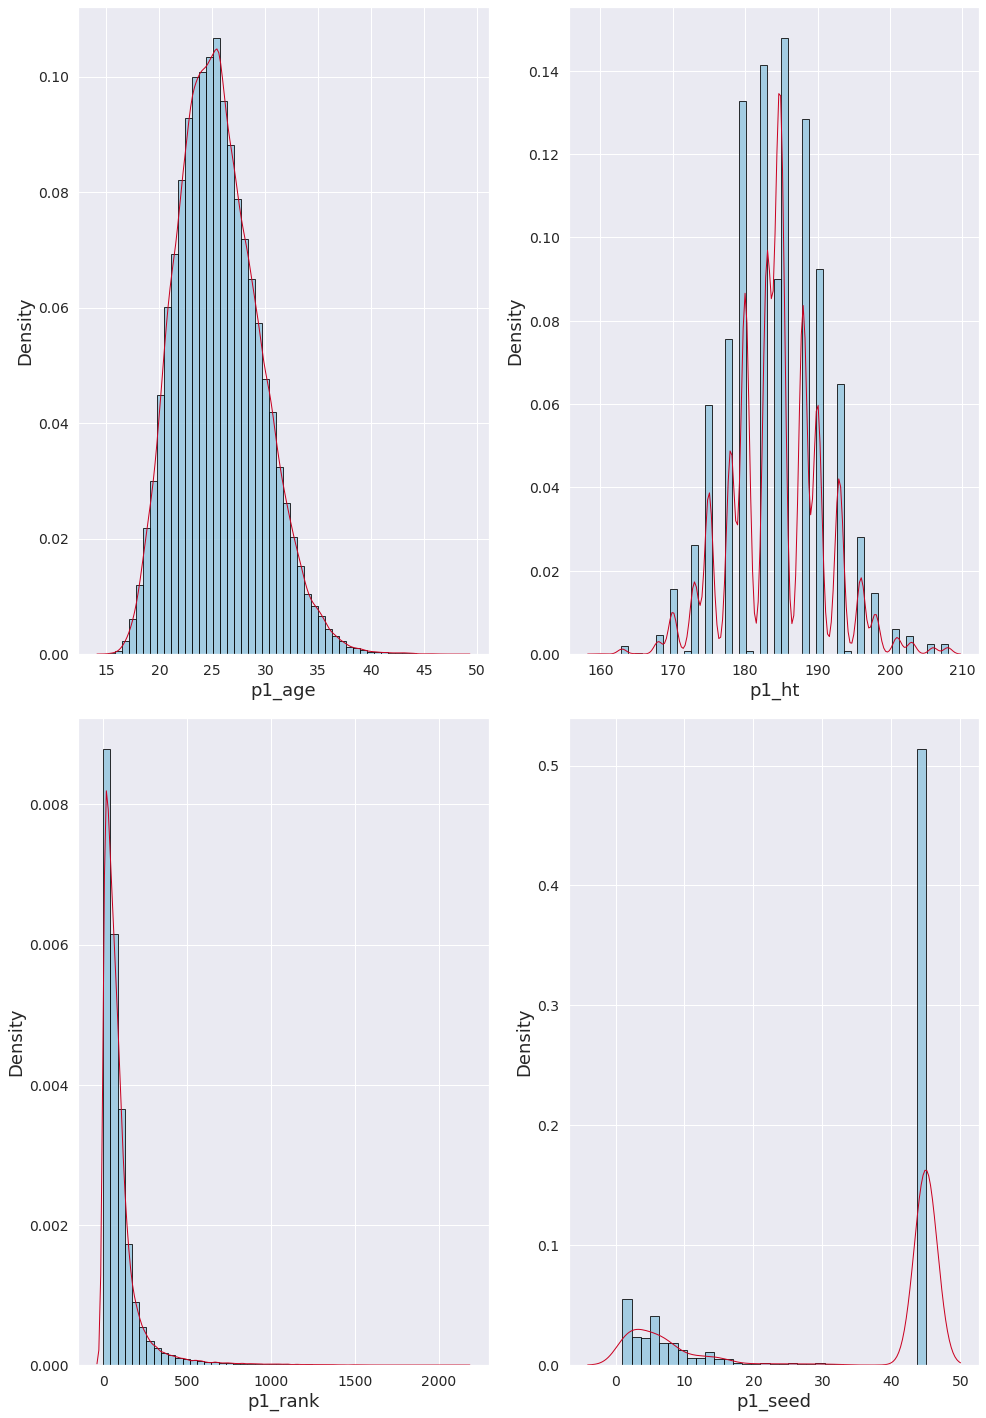

In [ ]:
# Plot the distribution of the interesting values of each column of interest
n_rows = 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14,20)) 
feature_stats = ['p1_age', 'p1_ht', 'p1_rank', 'p1_seed']

for i,f in enumerate(feature_stats):
    _ = sns.distplot(pd_data[f],
                    kde_kws={"color": "#ca0020", "lw": 1}, 
                    hist_kws={"histtype": "bar", "edgecolor": "k", "linewidth": 1,"alpha": 0.8, "color": "#92c5de"},
                    ax=axes[i//n_cols, i%n_cols]
                    )

fig.tight_layout(pad=1.5)

**Pairwise Regression Plots** -- *10 minutes run time*

Plot the pairwise relationship between our numerical features: we can see that the most relevant relationship in our case is between the parameters *p1_rank* and *p2_rank*. As expected, the ATP ranking of the players is the most important parameter for the correct prediction of the outcome of a tennis match. The relationship between *p1_seed* and *p2_seed* is also relevant, but can be considered a subset of the *ranking* classification.

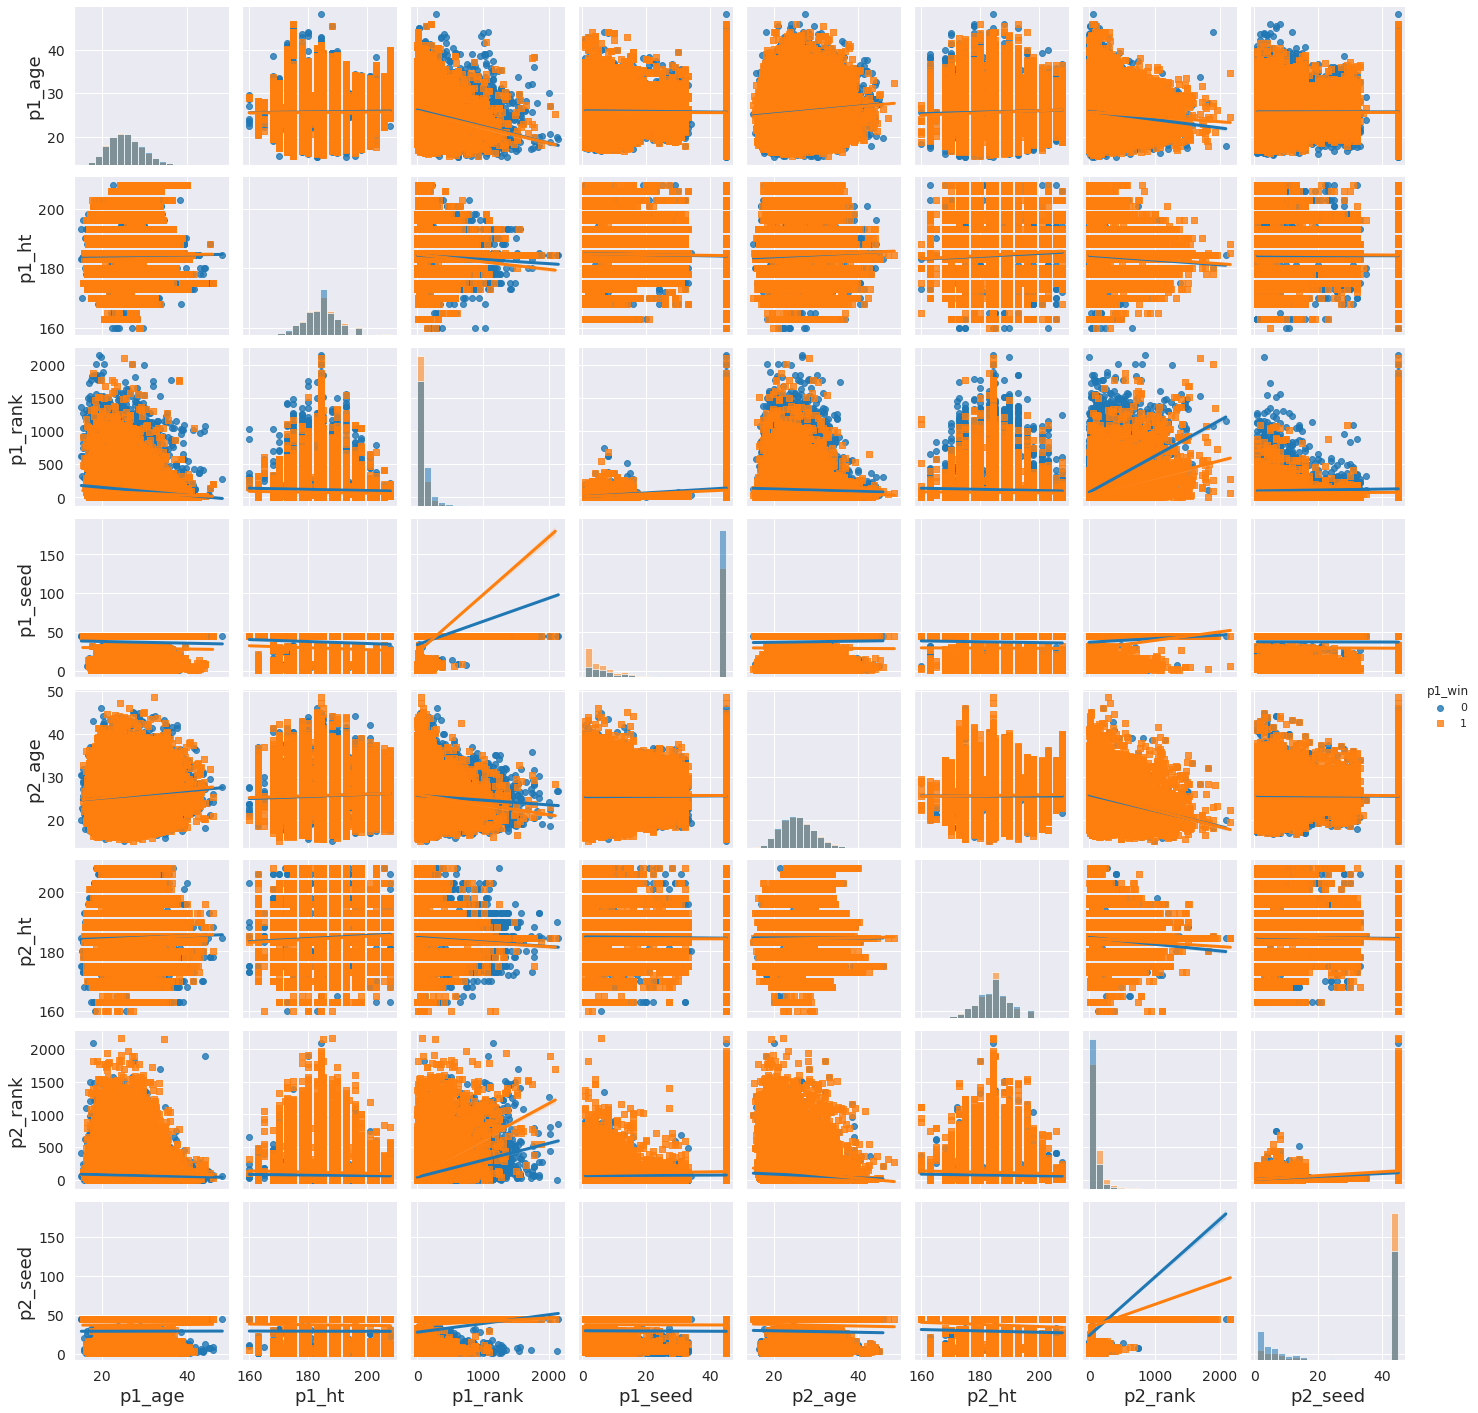

In [ ]:
numerical_features = ['p1_rank','p2_rank', 'p1_age', 'p2_age', 'p1_seed', 'p2_seed', 'p1_ht', 'p2_ht']

_ = sns.pairplot(data=pd_data, 
                 vars=sorted(numerical_features), 
                 hue=target, 
                 kind="reg",
                 diag_kind='hist',
                 diag_kws = {'alpha':0.55, 'bins':20},
                 markers=["o", "s"]
                )

**Categorical Features Analysis**

We can note the prevalence of:
- Matches at the best of 3 with respect to best of 5
- Right-handed players with respect to Left-handed players
- Statistics related to the *round* of the match, to the *level* of the tournament and to the *surface* (prevalence of *hard* and *clay* courts)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

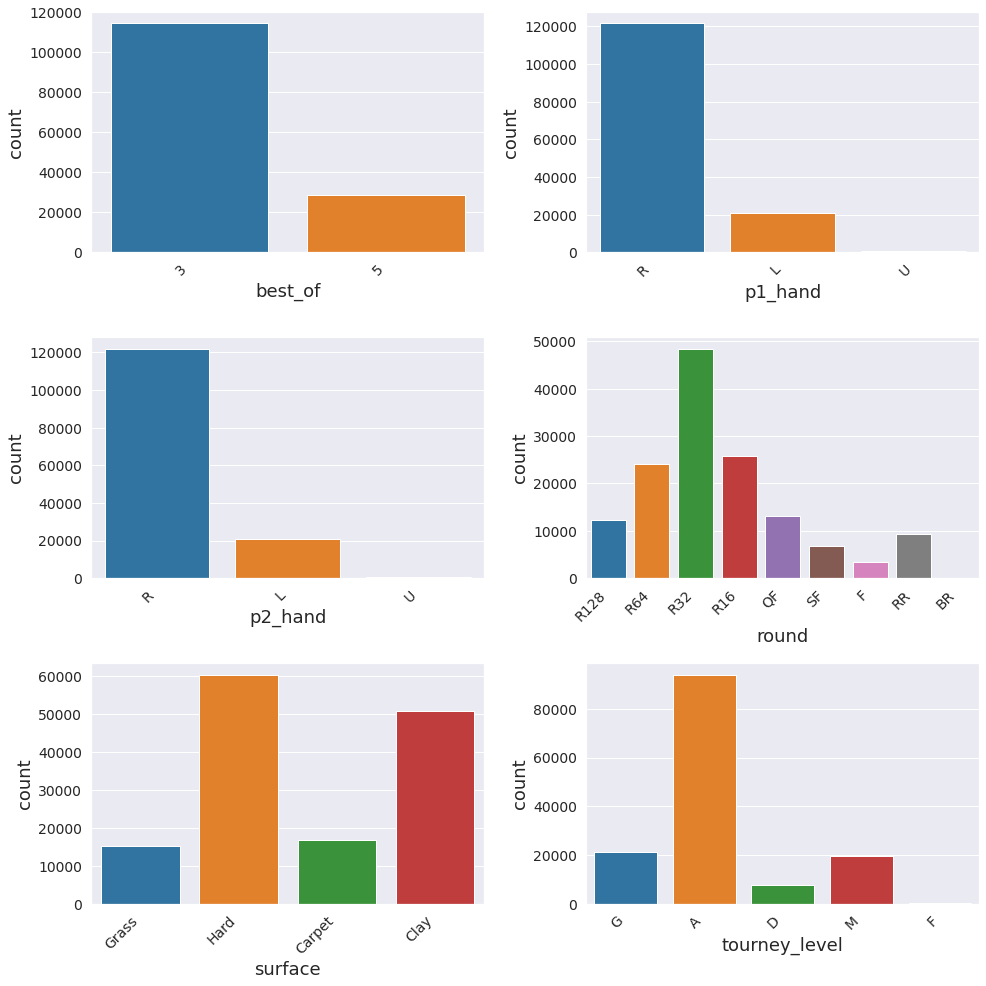

In [ ]:
#'Countplot' is used in this case
n_rows = 3
n_cols = 2

cat_features = ['best_of', 'p1_hand', 'round', 'surface', 'tourney_level', 'p2_hand']

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14,14))

for i,f in enumerate(sorted(cat_features)): 
    ax = sns.countplot(pd_data[f], ax=axes[i//n_cols, i%n_cols])
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

fig.tight_layout(pad=1.5)

# Learning Pipeline

## Define Numerical and Categorical Features
We will perform many trainings with different combinations of numerical and categorical features, in order to understand the best combination.

In [ ]:
#-- ALL THE FEATURES --#
#numerical_features = ["p1_age", "p1_ht", "p1_rank", "p1_seed", "p2_age", "p2_ht", "p2_rank", "p2_seed"]  ## 8 numerical features
#categorical_features = [ "p1_hand", "p2_hand", "best_of", "round", "surface", "tourney_level"]  ## 6 categorical features

#-- ALL THE FEATURES, NO RANKING--#
#numerical_features = ["p1_age", "p1_ht", "p2_age", "p2_ht", "p1_seed", "p2_seed"]  ## 6 numerical features
#categorical_features = [ "p1_hand", "p2_hand", "best_of", "round", "surface", "tourney_level"]  ## 6 categorical features

#-- ALL THE FEATURES, NO SEED --#
numerical_features = ["p1_age", "p1_ht", "p2_age", "p2_ht", "p1_rank", "p2_rank"]  ## 6 numerical features
categorical_features = [ "p1_hand", "p2_hand", "best_of", "round", "surface", "tourney_level"]  ## 6 categorical features

#-- NO RANKING/SEED --#
#numerical_features = ["p1_age", "p2_age", "p1_ht",  "p2_ht"]  ## 4 numerical features
#categorical_features = ["best_of", "p1_hand", "round", "surface", "tourney_level", "p2_hand"]  ## 6 categorical features

#-- ONLY RANKING --#
#numerical_features = ["p1_rank", "p2_rank"]  ## 2 numerical features
#categorical_features = []  ## 0 categorical features

#-- ONLY SEED --#
#numerical_features = ["p1_seed", "p2_seed"]  ## 2 numerical features
#categorical_features = []  ## 0 categorical features

target = "p1_win"

#Not Used Parameters
#p1_name, p1_rank_points, tourney_date, p2_name, p2_rank_points, p1_id, p2_id

## Data Processing Functions

**Pipeline Vector Creation**

The categorical parameters are indexed to make them available for the training, the label is indexed and the numerical parameters are added to the pipeline that has just been created. 

In [ ]:
def transform_categorical(numerical_features, categorical_features, target_variable):

    #For each categorical feature, changes the column string name to an index
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]
    
    #The target variable is indexed: in our case, inversion between '0' and '1'
    #Now, '1' is a p1 loss and '0' is a p1 win 
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")

    #The numerical features are added to the vector
    assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers]+ numerical_features, outputCol="features")

    #Add the Standardization of the Features
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), 
                            withStd=True, withMean=True)

    # Populate the stages of the pipeline with all the preprocessing steps
    #pipeline_vector = indexers + [label_indexer] + [assembler]   ##Normal features
    pipeline_vector = indexers + [label_indexer] + [assembler] + [scaler]   ##Standardized features

    return pipeline_vector

**One-Hot Encoding**

Same pipeline creation as the one above, but One-Hot-Encoding is performed on the Categorical features.

In [ ]:
def transform_one_hot(numerical_features, categorical_features, target_variable):

    #For each categorical feature, changes the column string name to an index
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")
    
    #The target variable is indexed: in our case, inversion between '0' and '1' 
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")

    #The numerical features are added to the vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, outputCol="features")

    #Add the Standardization of the Features
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), 
                            withStd=True, withMean=True)

    # Populate the stages of the pipeline with all the preprocessing steps
    #pipeline_vector = indexers + [encoder] + [label_indexer] + [assembler]   ##Normal features
    pipeline_vector = indexers + [encoder] + [label_indexer] + [assembler] + [scaler]  ##Standardized features

    return pipeline_vector

**Feature Normalization**

All the encoded features are standardized. The *standardize_features* function creates a new column called **std_features** where the vector of standardized features is saved. This function will be used in the Artificial Neural Network section to process the data. 

In [ ]:
def standardize_features(df, input_col="features", with_std=True, with_mean=True):

    # 1. Create the StandardScaler
    scaler = StandardScaler(inputCol=input_col, outputCol="std_"+input_col, withStd=with_std, withMean=with_mean)

    # 2. Compute summary statistics by fitting the StandardScaler
    scaler_model = scaler.fit(df)

    # 3. Normalize each feature to have 0-mean and unit standard deviation
    scaled_data = scaler_model.transform(df)

    # 4. Eventually, return both the scaler_model (for future transformations) and the scaled data
    return scaler_model, scaled_data

## Dataset Train/Test Split

**Initial Dataset**

In [ ]:
# Randomly split our original spark dataset into 80÷20 for Training and Testing
train_df, test_df = sp_data.randomSplit([0.80, 0.20])

print("Training set size: {:d} instances".format(train_df.count()))
print("Test set size: {:d} instances".format(test_df.count()))

Training set size: 114575 instances
Test set size: 28700 instances


**Calculate the new prediction accuracy based only on the rankings.**

In [ ]:
#Create the Pandas Dataframes 
pd_sp_data = sp_data.toPandas()
pd_train_df = train_df.toPandas()
pd_test_df = test_df.toPandas() 

count = calc_ranking_prediction(pd_sp_data)
print("Prediction accuracy on the whole dataset: ", count/len(pd_sp_data))

count = calc_ranking_prediction(pd_train_df)
print("Prediction accuracy on the train set: ", count/len(pd_train_df))

count = calc_ranking_prediction(pd_test_df)
print("Prediction accuracy on the test set: ", count/len(pd_test_df))

Prediction accuracy on the whole dataset:  0.6627604257546676
Prediction accuracy on the train set:  0.662657647828933
Prediction accuracy on the test set:  0.6631707317073171


# Logistic Regression

Logistic Regression is the first Machine Learning model technique that we will use to predict the OUTCOME of each tennis match.

**Pipeline**

In the case of the k-fold pipeline, we can choose to use the **Initial** dataset or the **Standardized** dataset by commenting and uncommenting the two lines of code at Lines 17 and 18.

In [ ]:
def pipe_logistic(dataframe, pipeline_vector):
  
  log_reg = LogisticRegression(featuresCol = "features", labelCol = "label", maxIter=100)
  pipeline = Pipeline(stages=pipeline_vector)

  transformer = pipeline.fit(dataframe)
  df_transformed = transformer.transform(dataframe)

  log_reg_model = log_reg.fit(df_transformed)

  return log_reg_model, transformer, df_transformed


def pipe_logistic_kfold(dataframe, pipeline_vector, k_fold=3):

    # Create the logistic regression transformer
    log_reg = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100) 
    #log_reg = LogisticRegression(featuresCol="std_features", labelCol="label", maxIter=100)  # Standard Features

    pipeline_vector += [log_reg]

    # Pipeline
    pipeline = Pipeline(stages=pipeline_vector)
 
    #ParamGridBuilder --> grid of parameters to search over
    param_grid = ParamGridBuilder().addGrid(log_reg.regParam, [0.0, 0.05, 0.1]).addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0]).build()
    
    cross_val = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                               numFolds=k_fold, collectSubModels=True)

    # Run cross-validation, and choose the best set of parameters.
    log_model = cross_val.fit(dataframe)

    return log_model

**Use of the Initial Dataset**

Comment the Line 23 and uncomment Line 22 in the function *transform_one_hot* to use *'features'* in Logistic Regression.

In [ ]:
pipeline_vector = transform_one_hot(numerical_features, categorical_features, target)
log_reg_model, log_transformer, train_df_transformed = pipe_logistic(train_df, pipeline_vector)
print(train_df_transformed)

+-------+------+-------+------------------+------+------------------+-------+-------+-----+-------+------------+-------------+-----------------+-------+------------------+------+--------------------+-------+-------+------+---------------+---------------+---------------+-------------+---------------+---------------------+-----------------------+-----------------------------+---------------------+-----------------------+-----------------------+-----------------------+-----+--------------------+
|best_of|p1_age|p1_hand|             p1_ht| p1_id|           p1_name|p1_rank|p1_seed|round|surface|tourney_date|tourney_level|           p2_age|p2_hand|             p2_ht| p2_id|             p2_name|p2_rank|p2_seed|p1_win|p1_hand_indexed|p2_hand_indexed|best_of_indexed|round_indexed|surface_indexed|tourney_level_indexed|p2_hand_indexed_encoded|tourney_level_indexed_encoded|round_indexed_encoded|p1_hand_indexed_encoded|best_of_indexed_encoded|surface_indexed_encoded|label|            features|
+---

**Use of the Standardized Dataset**

Comment the Line 22 and uncomment Line 23 in the function *transform_one_hot* to use *'features'* in Logistic Regression.

In [ ]:
pipeline_vector = transform_one_hot(numerical_features, categorical_features, target)
log_reg_model, log_transformer, train_df_transformed = pipe_logistic(train_df, pipeline_vector)
print(train_df_transformed)

+-------+------+-------+------------------+------+------------------+-------+-------+-----+-------+------------+-------------+-----------------+-------+------------------+------+--------------------+-------+-------+------+---------------+---------------+---------------+-------------+---------------+---------------------+-----------------------+-----------------------------+---------------------+-----------------------+-----------------------+-----------------------+-----+--------------------+--------------------+
|best_of|p1_age|p1_hand|             p1_ht| p1_id|           p1_name|p1_rank|p1_seed|round|surface|tourney_date|tourney_level|           p2_age|p2_hand|             p2_ht| p2_id|             p2_name|p2_rank|p2_seed|p1_win|p1_hand_indexed|p2_hand_indexed|best_of_indexed|round_indexed|surface_indexed|tourney_level_indexed|p2_hand_indexed_encoded|tourney_level_indexed_encoded|round_indexed_encoded|p1_hand_indexed_encoded|best_of_indexed_encoded|surface_indexed_encoded|label|     

**k-Fold Model** -- *10 minutes run time*

We can always decide to use standardized features or not commenting the related Lines in the *transform_one_hot* function.

We can also decide to use *one_hot_encoding* or not.

In [ ]:
#One-Hot Encoding
pipeline_vector = transform_one_hot(numerical_features, categorical_features, target)
model = pipe_logistic_kfold(train_df, pipeline_vector)

#No One-Hot Encoding
#pipeline_vector = transform_categorical(numerical_features, categorical_features, target)
#model = pipe_logistic_kfold(scaled_train, pipeline_vector)

Evaluation: 

1.   single model --> *Complete Evaluation - Logistic Regression*
2.   k-fold model --> *K-fold Evaluation - All Methods*

# Random Forest

The second technique that we are using is Random Forest: we hope that this ensemble method will outperform Logistic Regression.

**Pipeline**

In [ ]:
def pipe_random_forest(dataframe, pipeline_vector, k_fold=3):

    random_forest = RandomForestClassifier(featuresCol="features", labelCol="label") #Normal Features
    #random_forest = RandomForestClassifier(featuresCol="std_features", labelCol="label")  #Standardized Features

    pipeline_vector += [random_forest]

    pipeline = Pipeline(stages=pipeline_vector)

    #ParamGridBuilder --> grid of parameters to search over
    param_grid = ParamGridBuilder().addGrid(random_forest.maxDepth, [5, 8, 10]).addGrid(random_forest.numTrees, [50, 100, 150]).build()
    
    #CrossValidator --> performing of k-fold evaluation
    cross_val = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, 
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), numFolds=k_fold, 
                               collectSubModels=True) #To save all the models from the k-fold

    # Run cross-validation, and choose the best set of parameters.
    rf_model = cross_val.fit(dataframe)

    return rf_model

Creation of the DataFrame for the Random Forest classifier -- *15 minutes run time*

In [ ]:
#pipeline_vector = transform_categorical(numerical_features, categorical_features, target)
pipeline_vector = transform_one_hot(numerical_features, categorical_features, target)

#Random Forest model
model = pipe_random_forest(train_df, pipeline_vector)

For the evaluation, go to the *K_Fold Evaluation* section.

# Gradient Boosted Decision Tree

**Pipeline**

In [ ]:
def pipe_boosting(dataframe, pipeline_vector, k_fold=3):

    boosting = GBTClassifier(featuresCol="features", labelCol="label") # Normal Features, StepSize(learning rate)=0.1 default
    #boosting = GBTClassifier(featuresCol="std_features", labelCol="label") # Standardized Features

    pipeline_vector += [boosting]

    pipeline = Pipeline(stages=pipeline_vector)

    #ParamGridBuilder --> grid of parameters to search over
    param_grid = ParamGridBuilder().addGrid(boosting.maxDepth, [3, 5, 8]).addGrid(boosting.maxIter, [10, 50, 100]).build()
    
    #CrossValidator --> performing of k-fold evaluation
    cross_val = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, 
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), numFolds=k_fold, 
                               collectSubModels=True) #To save all the models from the k-fold

    # Run cross-validation, and choose the best set of parameters.
    gbdt_model = cross_val.fit(dataframe)

    return gbdt_model

Creation of the DataFrame for the Boosted Decision Tree classifier -- *20 minutes run time*

In [ ]:
#pipeline_vector = transform_categorical(numerical_features, categorical_features, target)
pipeline_vector = transform_one_hot(numerical_features, categorical_features, target)

#Boosting model
model = pipe_boosting(train_df, pipeline_vector)

For the evaluation, go to the *K_Fold Evaluation* section.

# Evaluation

## Complete Evaluation - Logistic Regression

Logistic Regression - Intercept and Coefficients

In [ ]:
print("Intercept: {:.5f}".format(log_reg_model.intercept))
print("{:d} Coefficients: [{:s}]".format(len(log_reg_model.coefficients), ",".join(["{:.3f}".format(c) for c in log_reg_model.coefficients])))

Intercept: -0.00155
38 Coefficients: [-0.018,0.034,-0.114,0.000,0.027,-0.015,-0.024,0.000,0.047,-0.038,0.000,-0.002,0.006,0.016,-0.002,0.015,-0.024,-0.011,-0.005,-0.860,0.000,0.009,-0.002,-0.008,0.006,0.000,-0.035,0.058,-0.014,0.070,0.033,0.000,-0.025,0.005,0.025,-0.005,-0.006,0.006]


Calculate the accuracy of the prediction

In [ ]:
preds_train = log_reg_model.transform(train_df_transformed)

res = preds_train.select("label", "prediction").where(preds_train.label == preds_train.prediction).count()
print("Accuracy in the prediction: ", res/train_df.count())

Accuracy in the prediction:  0.6555967706742308


We calculate the weight of each parameter in our model.

**OBSERVATION**: as expected, two parameters make most of the prediction in our case, and they are *'p1_rank'* and *'p2_rank'*

In [ ]:
sns.set_style("darkgrid")
sns.set_context("notebook", rc={"lines.linewidth": 2, 
                                "xtick.labelsize":14, 
                                "ytick.labelsize":14,
                                "axes.labelsize": 18,
                                "axes.titlesize": 20,
                                })

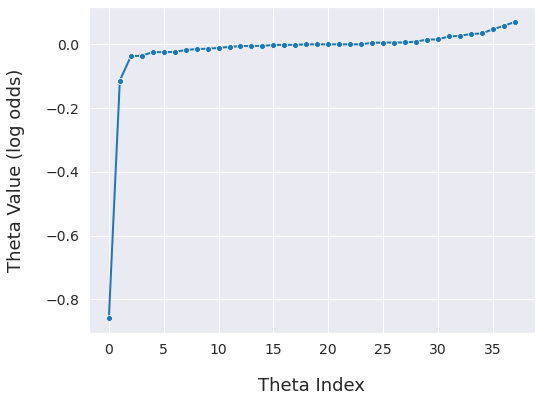

In [ ]:
theta = np.sort(log_reg_model.coefficients)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
_ = sns.lineplot(x=range(0,len(log_reg_model.coefficients)), y=theta, marker="o", axes=ax)
_ = ax.set_xlabel("Theta Index", labelpad=20)
_ = ax.set_ylabel("Theta Value (log odds)", labelpad=20)

*Precision-Recall*

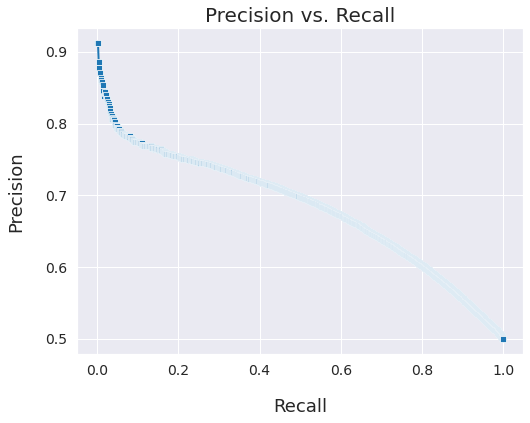

In [ ]:
# Training summary
training_summary = log_reg_model.summary
precision_recall = training_summary.pr.toPandas()

fig, ax = plt.subplots(1, 1, figsize=(8,6))
_ = sns.lineplot(x=precision_recall['recall'], y=precision_recall['precision'], marker="s", axes=ax)
_ = ax.set_xlabel("Recall", labelpad=20)
_ = ax.set_ylabel("Precision", labelpad=20)
_ = ax.set_title("Precision vs. Recall")

*ROC Curve*

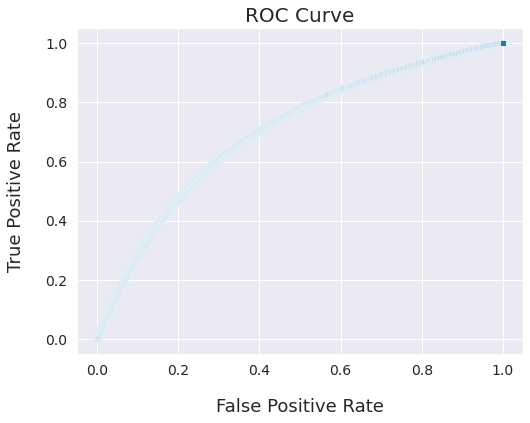

In [ ]:
# Training summary
training_summary = log_reg_model.summary
roc = training_summary.roc.toPandas()

fig, ax = plt.subplots(1, 1, figsize=(8,6))
_ = sns.lineplot(x=roc['FPR'], y=roc['TPR'], marker="s", axes=ax)
_ = ax.set_xlabel("False Positive Rate", labelpad=20)
_ = ax.set_ylabel("True Positive Rate", labelpad=20)
_ = ax.set_title("ROC Curve")

*AUC (Area Under the Curve)*

In [ ]:
print('Training Set AUC: {:.3f}'.format(training_summary.areaUnderROC))

Training Set AUC: 0.703


**Test Set Evaluation**

In [ ]:
#Transform the Test Set
#We use the same transformer as the one returned by the 'to_numerical' or 'transform_one_hot' function above yet applied to the test set
test_df_encoder = log_transformer.transform(test_df)

In [ ]:
# Select 'features' and 'label' only
test = test_df_encoder.select(["features", "label"])
test.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(38,[0,4,8,16,22,...|  0.0|
|(38,[0,4,8,16,23,...|  0.0|
|(38,[0,4,8,12,22,...|  0.0|
|(38,[0,4,8,11,22,...|  1.0|
|(38,[0,5,8,16,21,...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [ ]:
# 'predictions': DataFrame containing the predictions made by 'log_reg_model' on the test set

predictions = log_reg_model.transform(test)
predictions.select("features", "prediction", "label").show(10)

res = predictions.select("label", "prediction").where(predictions.label == predictions.prediction).count()
print("Accuracy in the prediction: ", res/test_df.count())

+--------------------+----------+-----+
|            features|prediction|label|
+--------------------+----------+-----+
|(38,[0,4,8,16,22,...|       0.0|  0.0|
|(38,[0,4,8,16,23,...|       0.0|  0.0|
|(38,[0,4,8,12,22,...|       0.0|  0.0|
|(38,[0,4,8,11,22,...|       0.0|  1.0|
|(38,[0,5,8,16,21,...|       0.0|  0.0|
|(38,[1,5,8,13,21,...|       0.0|  0.0|
|(38,[0,4,8,11,24,...|       0.0|  0.0|
|(38,[0,4,8,13,21,...|       0.0|  0.0|
|(38,[0,4,8,13,22,...|       0.0|  1.0|
|(38,[1,4,8,12,22,...|       0.0|  0.0|
+--------------------+----------+-----+
only showing top 10 rows

Accuracy in the prediction:  0.6534843205574913


In [ ]:
#Evaluation on the final Test Set

evaluator = BinaryClassificationEvaluator()
print('Test Set AUC: {:.3f}'.format(evaluator.evaluate(predictions)))

Test Set AUC: 0.699


## K-fold Evaluation - All Methods

AUC for each model of the K-fold training.

In [ ]:
for i, avg_roc_auc in enumerate(model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.715
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.717
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.716
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.723
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.724
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.724
Avg. ROC AUC computed across k-fold cross validation for model setting #7: 0.726
Avg. ROC AUC computed across k-fold cross validation for model setting #8: 0.727
Avg. ROC AUC computed across k-fold cross validation for model setting #9: 0.727


**Best Model** Characteristics

In [ ]:
#Logistic Regression
print("Best model according to k-fold cross validation: lambda=[{:.3f}]; alfa=[{:.3f}]".
      format(model.bestModel.stages[-1]._java_obj.getRegParam(), 
             model.bestModel.stages[-1]._java_obj.getElasticNetParam(),
             )
      )
print(model.bestModel.stages[-1])

Best model according to k-fold cross validation: lambda=[0.000]; alfa=[1.000]
LogisticRegressionModel: uid=LogisticRegression_3c33eaea31b4, numClasses=2, numFeatures=47


In [ ]:
#Random Forest / Boosting
print("Best model according to k-fold cross validation: maxDept=[{:d}]".
      format(model.bestModel.stages[-1]._java_obj.getMaxDepth(), ))
print(model.bestModel.stages[-1])

Best model according to k-fold cross validation: maxDept=[10]
RandomForestClassificationModel: uid=RandomForestClassifier_9cae13717c9e, numTrees=150, numClasses=2, numFeatures=47


**TRAIN SET**

In [ ]:
preds_train = model.bestModel.transform(train_df)
print(model.bestModel)

res = preds_train.select("label", "prediction").where(preds_train.label == preds_train.prediction).count()
print("Accuracy in the prediction: ", res/train_df.count())

PipelineModel_e038c5def17b
Accuracy in the prediction:  0.7037422037422038


**TEST SET**

In [ ]:
test_predictions = model.bestModel.transform(test_df)
print(model.bestModel)

res = test_predictions.select("label", "prediction").where(test_predictions.label == test_predictions.prediction).count()
print("Accuracy in the prediction: ", res/test_df.count())

PipelineModel_e038c5def17b
Accuracy in the prediction:  0.6539111540318686


In [ ]:
test_predictions.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
|            features|prediction|label|
+--------------------+----------+-----+
|(47,[0,4,8,11,21,...|       1.0|  0.0|
|(47,[0,4,8,11,21,...|       0.0|  1.0|
|(47,[0,4,8,11,21,...|       0.0|  1.0|
|(47,[0,4,8,12,21,...|       0.0|  0.0|
|(47,[0,4,8,16,21,...|       1.0|  0.0|
+--------------------+----------+-----+
only showing top 5 rows



In [ ]:
print("-- Test Set Evaluation --")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderROC")))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))

-- Test Set Evaluation --
Area Under ROC Curve (ROC AUC): 0.719
Area Under Precision-Recall Curve: 0.711


# Artificial Neural Network

The last method that I tried in order to obtain better results is a simple **Artficial Neural Network**. It is known that *Logistic Regression* can be considered a neural network with only one layer: depending on the dataset structure and on the features, a neural network performs better or equal to *Logistic Regression*, but never worse. For this reason, it can be useful to try this method and see the differencies.

Build the One-Hot Encoding pipeline -- **DO NOT USE THE STANDARD SCALER** in the *'transform_one_hot'* function.

In [ ]:
#Build the One-Hot Encoding pipeline -- DO NOT USE THE STANDARD SCALER in this case
pipeline_vector = transform_one_hot(numerical_features, categorical_features, target)
pipeline = Pipeline(stages=pipeline_vector)

Choose the Dataset:
1. Original Dataset (the one used in the sections above)
2. Dataset with New Statistics (the one created in the section *'Create new statistics from the available data'*)

In [ ]:
#1)
transformer = pipeline.fit(sp_data)
df_transformed = transformer.transform(sp_data)

In [ ]:
#2)
transformer = pipeline.fit(data_final_stats)
df_transformed = transformer.transform(data_final_stats)

- Split the dataset in Training Set and Test Set
- Standardize the features

In [ ]:
df_transformed_train, df_transformed_val = df_transformed.randomSplit([0.80, 0.20])

#Standardization
scaler_model_train, scaled_train = standardize_features(df_transformed_train)
std_dataframe_train = scaled_train.select(["features", "std_features", "label"])

scaler_model_val, scaled_val = standardize_features(df_transformed_val)
std_dataframe_val = scaled_val.select(["features", "std_features", "label"])

Transform the train and validation Spark Dataframes in Pandas Dataframes

In [ ]:
pd_std_dataframe_train = std_dataframe_train.toPandas()
pd_std_dataframe_val = std_dataframe_val.toPandas()

Creation of the *list of standard features* for both the training set validation set.

In [ ]:
def create_df_list(pd_dataframe):
  df_list_data = []
  df_list_label = []
  
  for index, row in pd_dataframe.iterrows():
    df_list_label.append(row.label)
    df_list_data.append(row.std_features)

  return df_list_data, df_list_label

df_list_data_train, df_list_label_train = create_df_list(pd_std_dataframe_train)
df_list_data_val, df_list_label_val = create_df_list(pd_std_dataframe_val)

Creation of the *numpy arrays* for the training set and validation sets.

In [ ]:
#Create the numpy array for the train set
df_array_data_train = np.asarray(df_list_data_train)
df_array_label_train = to_categorical(np.asarray(df_list_label_train))

#Create the numpy array for the test set
df_array_data_val = np.asarray(df_list_data_val)
df_array_label_val = to_categorical(np.asarray(df_list_label_val))

print("Train set data shape: ", df_array_data_train.shape)
print("Train set label shape: ", df_array_label_train.shape)

print("Vaidation set data shape: ", df_array_data_val.shape)
print("Validation set label shape: ", df_array_label_val.shape)

Train set data shape:  (66445, 47)
Train set label shape:  (66445, 2)
Vaidation set data shape:  (16501, 47)
Validation set label shape:  (16501, 2)


Prediction of the outcome solely based on the ranking of the two players. 

In [ ]:
#Build Pandas Dataframe for the prediction only based on rankings
pd_train = df_transformed_train.toPandas()
pd_val = df_transformed_val.toPandas()

count_train = calc_ranking_prediction(pd_train)
count_val = calc_ranking_prediction(pd_val)

print("% of right predictions only based on rankings (train set): ", count_train/len(pd_train))  
print("% of right predictions only based on rankings (validation set): ", count_val/len(pd_val))    

% of right predictions only based on rankings (train set):  0.6502520881932425
% of right predictions only based on rankings (validation set):  0.6503242227743773


## Model

I create a very simple ANN, composed by **two Dense layers** and an **Output layer**. The two Dense layers have **32** and **8 units** respectively: these numbers are reasonable due to the fact that the number of features floats from 35 minimum to 50 maximum.

A big Network is not needed because the task I'm facing is relatively small, and this solution came out as the best one. **Dropout** and **Batch Normalization** are also used in the two Dense layers.

In [ ]:
features_num = df_array_data_train.shape[1]

#Functional Model
visible1 = Input(shape=(features_num))

dense1 = Dense(32, activation='relu')(visible1)
drop1 = Dropout(0.2)(dense1)
batch1 = BatchNormalization()(drop1)

dense2 = Dense(8, activation='relu')(batch1)
drop2 = Dropout(0.2)(dense2)
batch2 = BatchNormalization()(drop2)

#Binary Classification
output = Dense(2, activation='sigmoid')(batch2)

model = Model(inputs=visible1, outputs=output)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 47)]              0         
                                                                 
 dense_3 (Dense)             (None, 32)                1536      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 8)                 264       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                           

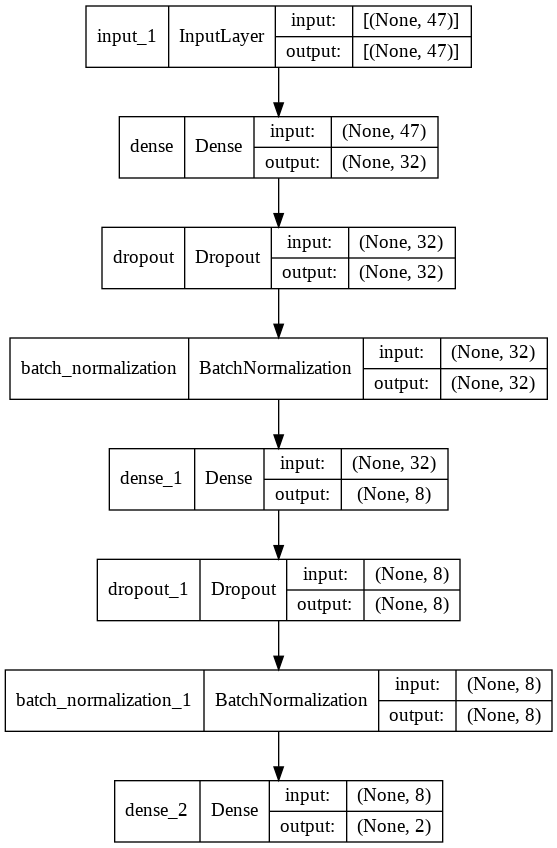

In [ ]:
#Plot the model
plot_model(model, show_shapes=True, show_layer_names=True)

## Training

*5-10 minutes run time*

In [ ]:
EPOCHS = 100
logging.getLogger('PIL').setLevel(logging.WARNING)

model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = Adam(learning_rate = 0.0002),
              metrics = ['acc'])

#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

fit_history = model.fit(
    df_array_data_train,
    df_array_label_train,                  
    epochs = EPOCHS,
    #callbacks=[callback],
    batch_size = 128,
    validation_data = (df_array_data_val, df_array_label_val)
)

Epoch 1/100
520/520 [==============================] - 3s 5ms/step - loss: 0.7526 - acc: 0.5426 - val_loss: 0.6663 - val_acc: 0.6129
Epoch 2/100
520/520 [==============================] - 2s 4ms/step - loss: 0.6815 - acc: 0.6044 - val_loss: 0.6400 - val_acc: 0.6427
Epoch 3/100
520/520 [==============================] - 2s 5ms/step - loss: 0.6626 - acc: 0.6190 - val_loss: 0.6310 - val_acc: 0.6500
Epoch 4/100
520/520 [==============================] - 2s 4ms/step - loss: 0.6507 - acc: 0.6315 - val_loss: 0.6258 - val_acc: 0.6521
Epoch 5/100
520/520 [==============================] - 2s 4ms/step - loss: 0.6435 - acc: 0.6358 - val_loss: 0.6218 - val_acc: 0.6548
Epoch 6/100
520/520 [==============================] - 2s 5ms/step - loss: 0.6374 - acc: 0.6399 - val_loss: 0.6191 - val_acc: 0.6555
Epoch 7/100
520/520 [==============================] - 2s 5ms/step - loss: 0.6347 - acc: 0.6442 - val_loss: 0.6174 - val_acc: 0.6540
Epoch 8/100
520/520 [==============================] - 2s 5ms/step - 

**OBSERVATION**

- 1st Dataset results: **0.5%** better than the prediction based only on rankings.
- 2nd Dataset results: **1.5%** better than the prediction based only on rankings.



# Create new Statistics from the Available Data

From the results obtained with the original dataset, we can say that the ranking of the two players is essential to the prediction of the outcome of the match. All the other parameters combined improve the prediction by the **0.5%**.

---

For this reason, being a tennis fan and knowing the key statistics that determine the strength of a player, I decided to create new statistics for each player to add to the Dataframe. All of these new stats depend on the previous matches played by the same player, and fortunately all the matches are put in chronological order.

---

The new statistics that I created for each player (always considered up to that moment in time) are:
- **Win Percentage** of a player on the *Surface* where the match is played 
- **Break Points Saved** percentage 
- **Break Points Won** percentage 
- **Break Points Obtained - Break Points Conceded Ratio**


**1st step**: load the original dataset and delete all the matches entries where there isn't all the needed information to create the new statistics.

In [ ]:
#Load the original dataset 
original_data = spark.read.csv(file_path, sep=',', header=True, inferSchema=True)

#Eliminate all the entries where even ONLY ONE of these parameters is NULL
original_data = original_data.dropna(subset=['loser_rank', 'winner_rank', 'l_bpFaced', 'l_bpSaved', 'loser_id', 'loser_hand',
                                             'round', 'surface', 'w_bpFaced', 'w_bpSaved', 'winner_hand', 'winner_id'])

check_null(original_data)

N. of Null values of column `best_of` = 0
N. of Null values of column `draw_size` = 82946
N. of Null values of column `l_1stIn` = 0
N. of Null values of column `l_1stWon` = 0
N. of Null values of column `l_2ndWon` = 0
N. of Null values of column `l_SvGms` = 0
N. of Null values of column `l_ace` = 0
N. of Null values of column `l_bpFaced` = 0
N. of Null values of column `l_bpSaved` = 0
N. of Null values of column `l_df` = 0
N. of Null values of column `l_svpt` = 0
N. of Null values of column `loser_age` = 30
N. of Null values of column `loser_entry` = 65240
N. of Null values of column `loser_hand` = 0
N. of Null values of column `loser_ht` = 4498
N. of Null values of column `loser_id` = 0
N. of Null values of column `loser_ioc` = 0
N. of Null values of column `loser_name` = 0
N. of Null values of column `loser_rank` = 0
N. of Null values of column `loser_rank_points` = 940
N. of Null values of column `loser_seed` = 62968
N. of Null values of column `match_num` = 0
N. of Null values of c

##Data Modifications

We perform the same name changes as we did in the original modifications of the downloaded dataset.

In [ ]:
#Drop the entries with no advanced info (we need, for each match, the bp_faced and bp_saved stats of both players, the surface and the ID)

original_data = original_data.withColumnRenamed("l_bpFaced", "p1_bpFaced")
original_data = original_data.withColumnRenamed("l_bpSaved", "p1_bpSaved")
original_data = original_data.withColumnRenamed("loser_age", "p1_age")
original_data = original_data.withColumnRenamed("loser_ht", "p1_ht")
original_data = original_data.withColumnRenamed("loser_hand", "p1_hand")
original_data = original_data.withColumnRenamed("loser_id", "p1_id")
original_data = original_data.withColumnRenamed("loser_name", "p1_name")
original_data = original_data.withColumnRenamed("loser_rank", "p1_rank")
original_data = original_data.withColumnRenamed("loser_rank_points", "p1_rank_points")
original_data = original_data.withColumnRenamed("loser_seed", "p1_seed")

original_data = original_data.withColumnRenamed("w_bpFaced", "p2_bpFaced")
original_data = original_data.withColumnRenamed("w_bpSaved", "p2_bpSaved")
original_data = original_data.withColumnRenamed("winner_age", "p2_age")
original_data = original_data.withColumnRenamed("winner_ht", "p2_ht")
original_data = original_data.withColumnRenamed("winner_hand", "p2_hand")
original_data = original_data.withColumnRenamed("winner_id", "p2_id")
original_data = original_data.withColumnRenamed("winner_name", "p2_name")
original_data = original_data.withColumnRenamed("winner_rank", "p2_rank")
original_data = original_data.withColumnRenamed("winner_rank_points", "p2_rank_points")
original_data = original_data.withColumnRenamed("winner_seed", "p2_seed")

#p1_win == 0 means that p1 loses the match
original_data = original_data.withColumn("p1_win", lit(0))
print(original_data)

pd_original_data = original_data.toPandas()
print("Number of entries in the Dataset: ", len(pd_original_data))

+-------+---------+-------+--------+--------+-------+-----+----------+----------+----+------+------+-----------+-------+-----+------+---------+--------------------+-------+--------------+-------+---------+-------+-----+-----------------+-------+------------+----------+-------------+------------+-------+--------+--------+-------+-----+----------+----------+----+------+------+------------+-------+-----+------+----------+--------------------+-------+--------------+-------+------+
|best_of|draw_size|l_1stIn|l_1stWon|l_2ndWon|l_SvGms|l_ace|p1_bpFaced|p1_bpSaved|l_df|l_svpt|p1_age|loser_entry|p1_hand|p1_ht| p1_id|loser_ioc|             p1_name|p1_rank|p1_rank_points|p1_seed|match_num|minutes|round|            score|surface|tourney_date|tourney_id|tourney_level|tourney_name|w_1stIn|w_1stWon|w_2ndWon|w_SvGms|w_ace|p2_bpFaced|p2_bpSaved|w_df|w_svpt|p2_age|winner_entry|p2_hand|p2_ht| p2_id|winner_ioc|             p2_name|p2_rank|p2_rank_points|p2_seed|p1_win|
+-------+---------+-------+--------+

As for the original dataset:
- Swap all the information regarding the players (*p1* becomes *p2* and viceversa) for HALF of the entries.
- Change the '*p1_win*' parameter from 0 to 1 (meaning that *p1* wins the game) for the same HALF of the entries.

*1 hour run time*

In [ ]:
pd3_data = pd.read_csv(file3_path)
print(pd3_data)
already_done = True

if len(pd3_data) == 0:
  already_done = False
  for index, row in pd_original_data.iterrows():
    if index % 5000 == 0:
      print("Index: ", index)
    if index % 2 == 0:
      row = swap_values(row, 'p1_bpFaced', 'p2_bpFaced')
      row = swap_values(row, 'p1_bpSaved', 'p2_bpSaved')
      row = swap_values(row, 'p1_age', 'p2_age')
      row = swap_values(row, 'p1_hand', 'p2_hand')
      row = swap_values(row, 'p1_ht', 'p2_ht')
      row = swap_values(row, 'p1_id', 'p2_id')
      row = swap_values(row, 'p1_name', 'p2_name')
      row = swap_values(row, 'p1_rank', 'p2_rank')
      row = swap_values(row, 'p1_rank_points', 'p2_rank_points')
      row = swap_values(row, 'p1_seed', 'p2_seed')
      row['p1_win'] = 1
      pd3_data = pd3_data.append(row)
    else:
      pd3_data = pd3_data.append(row)

if already_done == True:
  print("\nThe creation of the dataset used to build the new statistics has already been done.")

       Unnamed: 0  Unnamed: 0.1  best_of  ...  p1_win  winner_entry  winner_ioc
0               0           NaN        3  ...       1           NaN         SWE
1               1           NaN        3  ...       0             Q         YUG
2               2           NaN        3  ...       1           NaN         GER
3               3           NaN        3  ...       0           NaN         AUS
4               4           NaN        3  ...       1           NaN         GER
...           ...           ...      ...  ...     ...           ...         ...
82941       82941           NaN        3  ...       0           NaN         CHI
82942       82942           NaN        3  ...       1           NaN         NOR
82943       82943           NaN        3  ...       0           NaN         ARG
82944       82944           NaN        3  ...       1           NaN         CHI
82945       82945           NaN        3  ...       0           NaN         ARG

[82946 rows x 56 columns]

The creation

The newly created dataset is stored in Google Drive in *'file3_path'*. As before, this is an operation that has to be run ONLY ONCE.

In [ ]:
if already_done == False:
  csv_medium = pd3_data.to_csv(file3_path)

## New Statistics

**Load Dataset**

The modified dataset is loaded from Google Drive

In [ ]:
#Spark DataFrame
data_new = spark.read.csv(file3_path, sep=',', header=True, inferSchema=True)

#Pandas DataFrame
pd_data_new = data_new.toPandas()

Functions needed to create the statistics:
- **update_dict**: this function takes a row of a Dataframe as an input and updates the dictionary. In particular, it checks if the ID of the two players of the match already exist. If they are present, it adds the new statistics concerning *Break Points* and *Wins on a surface* to the dictionary. If they are not present, it create a new instance in the dictionary representing the player himself.
- **retrieve_stats**: this function obtains info from the dictionary of a player in order to create the statistics that we are interested in. It's necessary to *handle many particuar cases*, such as the first match of a player, the first match of a player on a particular surface, or the case in which we would have a division by zero in the calculation of the ratio; I tried to add reasonably bad statistics for a new player, due to his probable inexperience on the ATP tour. At the end of the function, *update_dict* is called to update the dictionary with the statistics of the match. Finally, the function returns two arrays of four values each containing the statistics of the two players up to that moment.
- **create_new_stats**: this function iterates on the Dataframe containing all the matches. For each row, *retrieve_stats* is called and the stats of the two players are added to the 8 arrays where the statistics are saved match after match, in chronological order. For each game, there are 8 new statistics that we will use for the prediction, 4 for *p1* and 4 for *p2*. At the end of the function, *add_columns* is called, in order to complete our new Dataframe. Finally, the new Dataframe is returned.
- **add_columns**: this function corresponds to the *final step* of our process. It takes the 8 arrays (that are of the same length of the Dataframe) and transforms them into *8 new columns* of the Dataframe. 


In [ ]:
def update_dict(row):

   ID1 = row.p1_id
   ID2 = row.p2_id
   surface = row.surface
   if surface == 'None': surface = 'Hard'
   p1_win = row.p1_win
   #print(p1_win)

   #Retrieve info from the dictionary
   bpSaved1 = row.p1_bpSaved
   bpFaced1 = row.p1_bpFaced

   bpSaved2 = row.p2_bpSaved
   bpFaced2 = row.p2_bpFaced

   if ID1 in id_dict.keys():
     #Add new info
     id_dict[ID1][surface] = [id_dict[ID1][surface][0] + 1, id_dict[ID1][surface][1] + p1_win]
     id_dict[ID1]['num_matches'] += 1
     id_dict[ID1]['bpSaved'] += bpSaved1
     id_dict[ID1]['bpFaced'] += bpFaced1
     id_dict[ID1]['bpConverted'] += (bpFaced2-bpSaved2)
     id_dict[ID1]['bpObtained'] += bpFaced2
   else:
     #Create a new entry
     id_dict[ID1] = {}
     id_dict[ID1]['Carpet'] = [0, 0]   #[Num_matches_surface, won_matches_surface]
     id_dict[ID1]['Clay'] = [0, 0]
     id_dict[ID1]['Hard'] = [0, 0]
     id_dict[ID1]['Grass'] = [0, 0]
     id_dict[ID1][surface] = [1, p1_win]
     id_dict[ID1]['num_matches'] = 1
     id_dict[ID1]['bpSaved'] = bpSaved1
     id_dict[ID1]['bpFaced'] = bpFaced1
     id_dict[ID1]['bpConverted'] = (bpFaced2-bpSaved2)
     id_dict[ID1]['bpObtained'] = bpFaced2

   if ID2 in id_dict.keys():
     #Add new info
     id_dict[ID2][surface] = [id_dict[ID2][surface][0] + 1, id_dict[ID2][surface][1] + (1-p1_win)]
     id_dict[ID2]['num_matches'] += 1
     id_dict[ID2]['bpSaved'] += bpSaved2
     id_dict[ID2]['bpFaced'] += bpSaved2
     id_dict[ID2]['bpConverted'] += (bpFaced1-bpSaved1)
     id_dict[ID2]['bpObtained'] += bpFaced1
   else:
     #Create a new entry
     id_dict[ID2] = {}
     id_dict[ID2]['Carpet'] = [0, 0]
     id_dict[ID2]['Clay'] = [0, 0]
     id_dict[ID2]['Hard'] = [0, 0]
     id_dict[ID2]['Grass'] = [0, 0]
     id_dict[ID2][surface] = [1, 1-p1_win]
     id_dict[ID2]['num_matches'] = 1
     id_dict[ID2]['bpSaved'] = bpSaved2
     id_dict[ID2]['bpFaced'] = bpFaced2
     id_dict[ID2]['bpConverted'] = (bpFaced1-bpSaved1)
     id_dict[ID2]['bpObtained'] = bpFaced1


#Stats: [win%_surface, %pb_Saved, %pd_Converted, pbObtained/pbFaced]
def retrieve_stats(row):

  if row.surface == 'None': surface = 'Hard'
  else: surface = row.surface

  #Obtain info on the previous matches from the dictionary
  if row.p1_id in id_dict.keys():
    info_p1 = id_dict[row.p1_id]
    #print(info_p1[surface][0])
    
    if info_p1[surface][0] == 0:
      win_perc_surface = 0.3  #First match of the player on that surface
    else:
      win_perc_surface = info_p1[surface][1]/info_p1[surface][0] 
    
    if info_p1['bpFaced'] == 0:
      pb_Saved_perc = 1.0   #If no break points Faced, you got a reward
      pb_ratio = 2*info_p1['bpObtained']
    else:
      pb_Saved_perc = info_p1['bpSaved']/info_p1['bpFaced']
      pb_ratio = info_p1['bpObtained']/info_p1['bpFaced']
    
    if info_p1['bpObtained'] == 0:
      pb_Conv_perc = 0.0   #If no break points Obtained, you got a punishment
    else:
      pb_Conv_perc = info_p1['bpConverted']/info_p1['bpObtained']

    stats1 = [win_perc_surface, pb_Saved_perc, pb_Conv_perc, pb_ratio]
  else:
    #First ATP match for the player --> instantiated the stats with low average values (due to player inexperience)
    stats1 = [0.25, 0.50, 0.25, 0.5]
  
  if row.p2_id in id_dict.keys():
    info_p2 = id_dict[row.p2_id]
    #print(info_p2[surface][0])

    if info_p2[surface][0] == 0:
      win_perc_surface = 0.3  #First match of the player on that surface
    else:
      win_perc_surface = info_p2[surface][1]/info_p2[surface][0] 

    if info_p2['bpFaced'] == 0:
      pb_Saved_perc = 1.0   #If no break points Faced, you got a reward
      pb_ratio = 2*info_p2['bpObtained']
    else:
      pb_Saved_perc = info_p2['bpSaved']/info_p2['bpFaced']
      pb_ratio = info_p2['bpObtained']/info_p2['bpFaced']
    
    if info_p2['bpObtained'] == 0:
      pb_Conv_perc = 0.0   #If no break points Obtained, you got a punishment
    else:
      pb_Conv_perc = info_p2['bpConverted']/info_p2['bpObtained']

    stats2 = [win_perc_surface, pb_Saved_perc, pb_Conv_perc, pb_ratio]
  else:
    #First ATP match for the player --> instantiated the stats with low average values (due to player inexperience)
    stats2 = [0.25, 0.50, 0.25, 0.5]

  update_dict(row)
  return stats1, stats2

def create_new_stats(pd_dataframe):
  for index, row in pd_dataframe.iterrows():
    
    if index % 2000 == 0:
      print("Processed: %", 100*index/len(pd_dataframe))

    stats_ID1, stats_ID2 = retrieve_stats(row)

    win_perc_surface_p1.append(stats_ID1[0])
    pb_saved_perc_p1.append(stats_ID1[1])
    pb_conv_perc_p1.append(stats_ID1[2])
    pb_ratio_p1.append(stats_ID1[3])

    win_perc_surface_p2.append(stats_ID2[0])
    pb_saved_perc_p2.append(stats_ID2[1])
    pb_conv_perc_p2.append(stats_ID2[2])
    pb_ratio_p2.append(stats_ID2[3])
  
  pd_dataframe_updated = add_columns(pd_dataframe)
  return pd_dataframe_updated


def add_columns(pd_dataframe):
  pd_dataframe = pd_dataframe.assign(p1_surface_win_perc=pd.Series(np.asarray(win_perc_surface_p1)))
  pd_dataframe = pd_dataframe.assign(p1_saved_perc=pd.Series(np.asarray(pb_saved_perc_p1)))
  pd_dataframe = pd_dataframe.assign(p1_conv_perc=pd.Series(np.asarray(pb_conv_perc_p1)))
  pd_dataframe = pd_dataframe.assign(p1_ratio=pd.Series(np.asarray(pb_ratio_p1)))

  pd_dataframe = pd_dataframe.assign(p2_surface_win_perc=pd.Series(np.asarray(win_perc_surface_p2)))
  pd_dataframe = pd_dataframe.assign(p2_saved_perc=pd.Series(np.asarray(pb_saved_perc_p2)))
  pd_dataframe = pd_dataframe.assign(p2_conv_perc=pd.Series(np.asarray(pb_conv_perc_p2)))
  pd_dataframe = pd_dataframe.assign(p2_ratio=pd.Series(np.asarray(pb_ratio_p2)))

  return pd_dataframe


*id_dict*: dictionary to store the needed information to build the new statistics.

Structure: **{ID: {num_matches, surface1: [won, played], surface2: [won, played], ..., bp_Saved_sum, bp_Faced_sum, bp_Converted_sum, bp_Obtained_sum}}**

*win_perc_surface_p1*, *pb_saved_perc_p1*, *pb_conv_perc_p1*,  *pb_ratio_p1*, *win_perc_surface_p2*, *pb_saved_perc_p2*, *pb_conv_perc_p2*,  *pb_ratio_p2*: the statistics for each player are saved, match after match in chronological order. These arrays are finally added as columns to our dataset.

In [ ]:
id_dict = {}

#Stats Arrays
win_perc_surface_p1 = []; pb_saved_perc_p1 = []; pb_conv_perc_p1 = []; pb_ratio_p1 = []
win_perc_surface_p2 = []; pb_saved_perc_p2 = []; pb_conv_perc_p2 = []; pb_ratio_p2 = []

pd_data_new = create_new_stats(pd_data_new)

print("Updated Data with all the new statistics: ") 
print(pd_data_new)

Processed: % 0.0
Processed: % 2.4112072914908493
Processed: % 4.822414582981699
Processed: % 7.233621874472548
Processed: % 9.644829165963397
Processed: % 12.056036457454248
Processed: % 14.467243748945096
Processed: % 16.878451040435948
Processed: % 19.289658331926795
Processed: % 21.700865623417645
Processed: % 24.112072914908495
Processed: % 26.523280206399345
Processed: % 28.934487497890192
Processed: % 31.345694789381042
Processed: % 33.756902080871896
Processed: % 36.16810937236274
Processed: % 38.57931666385359
Processed: % 40.99052395534444
Processed: % 43.40173124683529
Processed: % 45.81293853832614
Processed: % 48.22414582981699
Processed: % 50.63535312130784
Processed: % 53.04656041279869
Processed: % 55.45776770428954
Processed: % 57.868974995780384
Processed: % 60.28018228727124
Processed: % 62.691389578762085
Processed: % 65.10259687025294
Processed: % 67.51380416174379
Processed: % 69.92501145323463
Processed: % 72.33621874472549
Processed: % 74.74742603621634
Processed

Print out some statistics of the dictionary: the **total number of players** and the **average number of matches played** by a player.

In [ ]:
pd_data_new = pd_data_new.drop(columns = ['_c0'], axis=1)

print("Number of total players: ", len(id_dict))
print("Average number of matches played by each player: ", len(pd_data_new)/len(id_dict))

Number of total players:  2039
Average number of matches played by each player:  40.67974497302599


**Average statistics of the players**

In [ ]:
print("Break Point Ratio: ", statistics.mean(pb_ratio_p1))
print("Break Points Converted Percentage: ", statistics.mean(pb_conv_perc_p1))
print("Break Points Saved Percentage: ", statistics.mean(pb_saved_perc_p1))

Break Point Ratio:  1.2681266049215785
Break Points Converted Percentage:  0.4006102272603682
Break Points Saved Percentage:  0.7400015772819287


**Save the dataset with the new statistics on Google Drive**

In [ ]:
if already_done == False:
  csv_medium = pd_data_new.to_csv(file4_path)

# New Learning Pipeline

Load the dataset with the new statistics from Google Drive.

In [ ]:
#Spark DataFrame Loading
data_final_stats = spark.read.csv(file4_path, sep=',', header=True, inferSchema=True)

#The added columns can be seen at the right end of the DataFrame
print(data_final_stats)

pd_data_final_stats = data_final_stats.toPandas()

+---+----------+-------+---------+-------+--------+--------+-------+-----+----------+----------+----+------+------+--------+-------+-----+------+------+--------------------+-------+--------------+-------+---------+-------+-----+-----------------+-------+------------+----------+-------------+------------+-------+--------+--------+-------+-----+----------+----------+----+------+------+--------+-------+-----+------+------+--------------------+-------+--------------+-------+-----------+---------+------+------------+----------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+
|_c0|Unnamed: 0|best_of|draw_size|l_1stIn|l_1stWon|l_2ndWon|l_SvGms|l_ace|p1_bpFaced|p1_bpSaved|l_df|l_svpt|p1_age|p1_entry|p1_hand|p1_ht| p1_id|p1_ioc|             p1_name|p1_rank|p1_rank_points|p1_seed|match_num|minutes|round|            score|surface|tourney_date|tourney_id|tourney_level|tourney_name|w_1stIn|w_1s

## Define Numerical and Categorical Features

We add the 8 new features (all numerical) to the list and have more possible combinations.

In [ ]:
#-- ALL THE FEATURES--#
#numerical_features = ["p1_age", "p1_ht", "p1_rank", "p2_age", "p2_ht", "p2_rank", 'p1_seed', 'p2_seed', 'p1_surface_win_perc', 
#                      'p2_surface_win_perc', 'p1_saved_perc', 'p2_saved_perc', 'p1_conv_perc', 'p2_conv_perc', 'p1_ratio', 'p2_ratio']  
                ## 16 numerical features
#categorical_features = [ "p1_hand", "p2_hand", "best_of", "round", "surface", "tourney_level"]  ## 6 categorical features


#-- ALL THE FEATURES, NO SEED --#
numerical_features = ["p1_age", "p1_ht", "p1_rank", "p2_age", "p2_ht", "p2_rank", 'p1_surface_win_perc', 'p2_surface_win_perc',
                      'p1_saved_perc', 'p2_saved_perc', 'p1_conv_perc', 'p2_conv_perc', 'p1_ratio', 'p2_ratio']  ## 14 numerical features
categorical_features = [ "p1_hand", "p2_hand", "best_of", "round", "surface", "tourney_level"]  ## 6 categorical features

#-- NO NEW FEATURES, SEED --#
#numerical_features = ["p1_age", "p2_age", "p1_ht", "p2_ht", "p1_rank", "p2_rank", 'p1_seed', 'p2_seed'] #8 categorical features
#categorical_features = [ "p1_hand", "p2_hand", "best_of", "round", "surface", "tourney_level"]  ## 6 categorical features

#-- NO NEW FEATURES, NO SEED --#
#numerical_features = ["p1_age", "p2_age", "p1_ht", "p2_ht", "p1_rank", "p2_rank"] #6 categorical features
#categorical_features = [ "p1_hand", "p2_hand", "best_of", "round", "surface", "tourney_level"]  ## 6 categorical features

target = 'p1_win'

## Dataset Preprocessing

Check for **NULL values** in the dataset.

In [ ]:
check_null_features(data_final_stats, numerical_features, categorical_features)

N. of Null values of column `best_of` = 0
N. of Null values of column `p1_age` = 17
N. of Null values of column `p1_hand` = 0
N. of Null values of column `p1_ht` = 3505
N. of Null values of column `p1_rank` = 0
N. of Null values of column `round` = 0
N. of Null values of column `surface` = 0
N. of Null values of column `tourney_level` = 0
N. of Null values of column `p2_age` = 14
N. of Null values of column `p2_hand` = 0
N. of Null values of column `p2_ht` = 3566
N. of Null values of column `p2_rank` = 0
N. of Null values of column `p1_surface_win_perc` = 0
N. of Null values of column `p1_saved_perc` = 0
N. of Null values of column `p1_conv_perc` = 0
N. of Null values of column `p1_ratio` = 0
N. of Null values of column `p2_surface_win_perc` = 0
N. of Null values of column `p2_saved_perc` = 0
N. of Null values of column `p2_conv_perc` = 0
N. of Null values of column `p2_ratio` = 0


1. Handle the *'seed'* parameters in the dataset: since different tournaments can have different number of seeds, I fixed the seed at 45 for Unseeded players.
2. Substitute the Mean *'height'* and *'age'* values to the few NULL entries that we still have for these two columns.
3. Print the **shape** of the dataset.

In [ ]:
#1)
data_final_stats = data_final_stats.na.fill(45, subset=['p1_seed', 'p2_seed'])

#2)
age_mean = (pd_data_final_stats['p1_age'].mean() + pd_data_final_stats['p2_age'].mean())/2
height_mean = (pd_data_final_stats['p1_ht'].mean() + pd_data_final_stats['p2_ht'].mean())/2
print("Age mean of players: ", age_mean)
print("Height mean of players:  {:f} cm".format(height_mean))

data_final_stats = data_final_stats.na.fill(age_mean, subset=['p1_age', 'p2_age'])
data_final_stats = data_final_stats.na.fill(height_mean, subset=['p1_ht', 'p2_ht'])

print("The shape of the dataset is {:d} rows by {:d} columns".format(data_final_stats.count(), len(data_final_stats.columns)))

Age mean of players:  25.864520357054133
Height mean of players:  185.205218 cm
The shape of the dataset is 82946 rows by 64 columns


Now, there are **no NULL values** anymore in the DataFrame.

In [ ]:
check_null_features(data_final_stats, numerical_features, categorical_features)

N. of Null values of column `best_of` = 0
N. of Null values of column `p1_age` = 0
N. of Null values of column `p1_hand` = 0
N. of Null values of column `p1_ht` = 0
N. of Null values of column `p1_rank` = 0
N. of Null values of column `round` = 0
N. of Null values of column `surface` = 0
N. of Null values of column `tourney_level` = 0
N. of Null values of column `p2_age` = 0
N. of Null values of column `p2_hand` = 0
N. of Null values of column `p2_ht` = 0
N. of Null values of column `p2_rank` = 0
N. of Null values of column `p1_surface_win_perc` = 0
N. of Null values of column `p1_saved_perc` = 0
N. of Null values of column `p1_conv_perc` = 0
N. of Null values of column `p1_ratio` = 0
N. of Null values of column `p2_surface_win_perc` = 0
N. of Null values of column `p2_saved_perc` = 0
N. of Null values of column `p2_conv_perc` = 0
N. of Null values of column `p2_ratio` = 0


## Model Training - Evaluation

Split our original spark dataset into 80÷20 for training and test.

In [ ]:
train_df, test_df = data_final_stats.randomSplit([0.80, 0.20])
pd_train = train_df.toPandas()
pd_test = test_df.toPandas()

In [ ]:
print("Training set size: {:d} instances".format(train_df.count()))
print("Test set size: {:d} instances".format(test_df.count()))

Training set size: 66378 instances
Test set size: 16568 instances


**Calculate the new prediction accuracy based only on the rankings.**

In [ ]:
count = calc_ranking_prediction(pd_data_final_stats)
print("Prediction accuracy on the whole dataset: ", count/len(pd_data_final_stats))

count = calc_ranking_prediction(pd_train)
print("Prediction accuracy on the train set: ", count/len(pd_train))

count = calc_ranking_prediction(pd_test)
print("Prediction accuracy on the test set: ", count/len(pd_test))

Prediction accuracy on the whole dataset:  0.6502664384057097
Prediction accuracy on the train set:  0.6515713037452168
Prediction accuracy on the test set:  0.6450386286817963


**OBSERVATION**: we can see that the prediction accuracy based only on the rankings is lower with this new dataset with respect to the initial dataset of about **1.0%**. We know that all the data needed to the calculation of the new statistics is only present for the matches after 1990 (the needed data was not available from 1968 to 1989). We can therefore deduce that the power of the rankings to predict the winner of a tennis match slightly decreases after 1990.

**Logistic Regression**

In [ ]:
#pipeline_vector = transform_categorical(numerical_features, categorical_features, target)
pipeline_vector = transform_one_hot(numerical_features, categorical_features, target)

log_reg_model, log_transformer, train_df_transformed = pipe_logistic(train_df, pipeline_vector)

Logistic Regression k-Fold -- *5 minutes run time*

In [ ]:
#pipeline_vector = transform_categorical(numerical_features, categorical_features, target)
pipeline_vector = transform_one_hot(numerical_features, categorical_features, target)

model = pipe_logistic_kfold(train_df, pipeline_vector)

**Random Forest** -- *13 minutes run time*

In [ ]:
#pipeline_vector = transform_categorical(numerical_features, categorical_features, target)
pipeline_vector = transform_one_hot(numerical_features, categorical_features, target)

#Random Forest model
model = pipe_random_forest(train_df, pipeline_vector)

**Boosting** -- *18 minutes run time*

In [ ]:
#pipeline_vector = transform_categorical(numerical_features, categorical_features, target)
pipeline_vector = transform_one_hot(numerical_features, categorical_features, target)

#Boosting model
model = pipe_boosting(train_df, pipeline_vector)

**Artificial Neural Network** 

To train this new dataset with our ANN, go to the *Artificial Neural Network* section, use the *'transform_one_hot'* function **WITHOUT** using the standard scaler and choose the Dataset number 2. 

**EVALUATION**

To evaluate the models on the *Test set*, go to the section *K-fold Evaluation - All Methods*.

# Real-Time Predictions

The last thing that I did for the project is a simulation of the prediction *'in real-time'*. The idea is to have a *.csv* file on Google Drive containing the upcoming ATP matches and the most recent ATP matches. Fortunately, I lately found the continuation of the initial dataset, updated with all matches until 2022, containing all the needed information to build the new statistics. The idea is to create a **continuity** with the previously built **dictionary** containing the statistics of each player. Then, it's possible to **choose the last entries** of this constantly evolving dataset (that we could imagine being the **upcoming matches** that still have to be played) and try to **predict the outcome** of the matches.

In [ ]:
#Load the Dataset with recent matches
current_matches = spark.read.csv(file5_path, sep=',', header=True, inferSchema=True)
current_matches = current_matches.dropna(subset=['loser_rank', 'winner_rank', 'l_bpFaced', 'l_bpSaved', 'loser_id', 'loser_hand',
                                             'round', 'surface', 'w_bpFaced', 'w_bpSaved', 'winner_hand', 'winner_id'])

#Eliminate all the entries where even ONLY ONE of these parameters is NULL
check_null(current_matches)

N. of Null values of column `tourney_id` = 0
N. of Null values of column `tourney_name` = 0
N. of Null values of column `surface` = 0
N. of Null values of column `draw_size` = 0
N. of Null values of column `tourney_level` = 0
N. of Null values of column `tourney_date` = 0
N. of Null values of column `match_num` = 0
N. of Null values of column `winner_id` = 0
N. of Null values of column `winner_seed` = 2447
N. of Null values of column `winner_entry` = 3489
N. of Null values of column `winner_name` = 0
N. of Null values of column `winner_hand` = 0
N. of Null values of column `winner_ht` = 446
N. of Null values of column `winner_ioc` = 0
N. of Null values of column `winner_age` = 0
N. of Null values of column `loser_id` = 0
N. of Null values of column `loser_seed` = 3148
N. of Null values of column `loser_entry` = 3190
N. of Null values of column `loser_name` = 0
N. of Null values of column `loser_hand` = 0
N. of Null values of column `loser_ht` = 711
N. of Null values of column `loser_io

##Data Modifications

We perform the same name changes as we did in the original modifications of the downloaded dataset.

In [ ]:
#Drop the entries with no advanced info (we need, for each match, the bp_faced and bp_saved stats of both players, the surface and the ID)

current_matches = current_matches.withColumnRenamed("l_bpFaced", "p1_bpFaced")
current_matches = current_matches.withColumnRenamed("l_bpSaved", "p1_bpSaved")
current_matches = current_matches.withColumnRenamed("loser_age", "p1_age")
current_matches = current_matches.withColumnRenamed("loser_ht", "p1_ht")
current_matches = current_matches.withColumnRenamed("loser_hand", "p1_hand")
current_matches = current_matches.withColumnRenamed("loser_id", "p1_id")
current_matches = current_matches.withColumnRenamed("loser_name", "p1_name")
current_matches = current_matches.withColumnRenamed("loser_rank", "p1_rank")
current_matches = current_matches.withColumnRenamed("loser_rank_points", "p1_rank_points")
current_matches = current_matches.withColumnRenamed("loser_seed", "p1_seed")

current_matches = current_matches.withColumnRenamed("w_bpFaced", "p2_bpFaced")
current_matches = current_matches.withColumnRenamed("w_bpSaved", "p2_bpSaved")
current_matches = current_matches.withColumnRenamed("winner_age", "p2_age")
current_matches = current_matches.withColumnRenamed("winner_ht", "p2_ht")
current_matches = current_matches.withColumnRenamed("winner_hand", "p2_hand")
current_matches = current_matches.withColumnRenamed("winner_id", "p2_id")
current_matches = current_matches.withColumnRenamed("winner_name", "p2_name")
current_matches = current_matches.withColumnRenamed("winner_rank", "p2_rank")
current_matches = current_matches.withColumnRenamed("winner_rank_points", "p2_rank_points")
current_matches = current_matches.withColumnRenamed("winner_seed", "p2_seed")

#p1_win == 0 means that p1 loses the match
current_matches = current_matches.withColumn("p1_win", lit(0))
print(current_matches)

pd_current_matches = current_matches.toPandas()
print("Number of entries in the new Dataset: ", len(pd_current_matches))

+----------+------------+-------+---------+-------------+------------+---------+------+-------+------------+--------------------+-------+-----+----------+-------------+------+-------+-----------+--------------------+-------+-----+---------+-------------+-----------------+-------+-----+-------+-----+----+------+-------+--------+--------+-------+----------+----------+-----+----+------+-------+--------+--------+-------+----------+----------+-------+--------------+-------+--------------+------+
|tourney_id|tourney_name|surface|draw_size|tourney_level|tourney_date|match_num| p2_id|p2_seed|winner_entry|             p2_name|p2_hand|p2_ht|winner_ioc|       p2_age| p1_id|p1_seed|loser_entry|             p1_name|p1_hand|p1_ht|loser_ioc|       p1_age|            score|best_of|round|minutes|w_ace|w_df|w_svpt|w_1stIn|w_1stWon|w_2ndWon|w_SvGms|p2_bpSaved|p2_bpFaced|l_ace|l_df|l_svpt|l_1stIn|l_1stWon|l_2ndWon|l_SvGms|p1_bpSaved|p1_bpFaced|p2_rank|p2_rank_points|p1_rank|p1_rank_points|p1_win|
+-------

As for the original dataset:
- Swap all the information regarding the players (*p1* becomes *p2* and viceversa) for HALF of the entries.
- Change the '*p1_win*' parameter from 0 to 1 (meaning that *p1* wins the game) for the same HALF of the entries.

*5 minutes run time*

In [ ]:
current_matches_new = pd.read_csv(file6_path)
print(current_matches_new)
already_done = True

if len(current_matches_new) == 0:
  already_done = False
  for index, row in pd_current_matches.iterrows():
    if index % 1000 == 0:
      print("Index: ", index)
    if index % 2 == 0:
      row = swap_values(row, 'p1_bpFaced', 'p2_bpFaced')
      row = swap_values(row, 'p1_bpSaved', 'p2_bpSaved')
      row = swap_values(row, 'p1_age', 'p2_age')
      row = swap_values(row, 'p1_hand', 'p2_hand')
      row = swap_values(row, 'p1_ht', 'p2_ht')
      row = swap_values(row, 'p1_id', 'p2_id')
      row = swap_values(row, 'p1_name', 'p2_name')
      row = swap_values(row, 'p1_rank', 'p2_rank')
      row = swap_values(row, 'p1_rank_points', 'p2_rank_points')
      row = swap_values(row, 'p1_seed', 'p2_seed')
      row['p1_win'] = 1
      current_matches_new = current_matches_new.append(row)
    else:
      current_matches_new = current_matches_new.append(row)

if already_done == True:
  print("The creation of the modified dataset containing the current matches (2020 to 2022) has already been done.")

      Unnamed: 0  Unnamed: 0.1  best_of  ...  p1_win  winner_entry  winner_ioc
0              0           NaN        3  ...       1           NaN         SRB
1              1           NaN        3  ...       0           NaN         ESP
2              2           NaN        3  ...       1           NaN         SRB
3              3           NaN        3  ...       0           NaN         SRB
4              4           NaN        3  ...       1           NaN         ESP
...          ...           ...      ...  ...     ...           ...         ...
4162        4162           NaN        3  ...       1           NaN         USA
4163        4163           NaN        3  ...       0            WC         AUS
4164        4164           NaN        3  ...       1           NaN         BEL
4165        4165           NaN        3  ...       0            LL         USA
4166        4166           NaN        3  ...       1            WC         GBR

[4167 rows x 56 columns]
The creation of the modifi

The newly created dataset is stored in Google Drive in *'file6_path'*. As before, this is an operation that has to be run ONLY ONCE.

In [ ]:
if already_done == False:
  csv_medium = current_matches_new.to_csv(file6_path)

# Learning Pipeline

## Load Dataset

Load the just created Dataset of current and recent ATP tennis matches from Google Drive.

In [ ]:
#Spark DataFrame
current_matches_new = spark.read.csv(file6_path, sep=',', header=True, inferSchema=True)

#Pandas DataFrame
pd_current_matches_new = current_matches_new.toPandas()

In [ ]:
check_null_features(current_matches_new, numerical_features, categorical_features)

N. of Null values of column `best_of` = 0
N. of Null values of column `p1_age` = 0
N. of Null values of column `p1_hand` = 0
N. of Null values of column `p1_ht` = 578
N. of Null values of column `p1_rank` = 0
N. of Null values of column `round` = 0
N. of Null values of column `surface` = 0
N. of Null values of column `tourney_level` = 0
N. of Null values of column `p2_age` = 0
N. of Null values of column `p2_hand` = 0
N. of Null values of column `p2_ht` = 579
N. of Null values of column `p2_rank` = 0


1. Handle the *'seed'* parameters in the dataset: since different tournaments can have different number of seeds, I fixed the seed at 45 for Unseeded players.
2. Substitute the Mean *'height'* and *'age'* values to the few NULL entries that we still have for these two columns.
3. Print the **shape** of the dataset.

In [ ]:
current_matches_new = current_matches_new.na.fill(45, subset=['p1_seed', 'p2_seed'])

age_mean = (pd_data_final_stats['p1_age'].mean() + pd_data_final_stats['p2_age'].mean())/2
height_mean = (pd_data_final_stats['p1_ht'].mean() + pd_data_final_stats['p2_ht'].mean())/2
print("Age mean of players: ", age_mean)
print("Height mean of players:  {:f} cm".format(height_mean))

current_matches_new = current_matches_new.na.fill(age_mean, subset=['p1_age', 'p2_age'])
current_matches_new = current_matches_new.na.fill(height_mean, subset=['p1_ht', 'p2_ht'])

Age mean of players:  25.864520357054133
Height mean of players:  185.205218 cm


**OBSERVATION**: there is no real *'streaming'* of data since there are only a few matches every day. The idea is that, every time a match comes, assuming it is entered in the correct format in the *.csv* file on Google Drive, we can decide to perform the prediction on a variable number of matches (assuming that they are the upcoming matches) contained at the end of
the Dataset.

**1st step**: fill the dictionary with the *old* matches and then, update it for the new matches contained in the *'current matches'* dataset.

In [ ]:
id_dict = {}
win_perc_surface_p1 = []; pb_saved_perc_p1 = []; pb_conv_perc_p1 = []; pb_ratio_p1 = []
win_perc_surface_p2 = []; pb_saved_perc_p2 = []; pb_conv_perc_p2 = []; pb_ratio_p2 = []

#'Old Matches' Dataset
create_new_stats(pd_data_final_stats)
print("Number of players in the dictionary with the 'Old Matches' dataset: ", len(id_dict))

#'New Matches' Dataset
pd_current_matches_new = create_new_stats(pd_current_matches_new)
print("Number of players in the dictionary updated with the 'New Matches' dataset: ", len(id_dict))

Processed: % 0.0
Processed: % 2.4112072914908493
Processed: % 4.822414582981699
Processed: % 7.233621874472548
Processed: % 9.644829165963397
Processed: % 12.056036457454248
Processed: % 14.467243748945096
Processed: % 16.878451040435948
Processed: % 19.289658331926795
Processed: % 21.700865623417645
Processed: % 24.112072914908495
Processed: % 26.523280206399345
Processed: % 28.934487497890192
Processed: % 31.345694789381042
Processed: % 33.756902080871896
Processed: % 36.16810937236274
Processed: % 38.57931666385359
Processed: % 40.99052395534444
Processed: % 43.40173124683529
Processed: % 45.81293853832614
Processed: % 48.22414582981699
Processed: % 50.63535312130784
Processed: % 53.04656041279869
Processed: % 55.45776770428954
Processed: % 57.868974995780384
Processed: % 60.28018228727124
Processed: % 62.691389578762085
Processed: % 65.10259687025294
Processed: % 67.51380416174379
Processed: % 69.92501145323463
Processed: % 72.33621874472549
Processed: % 74.74742603621634
Processed

**2nd step**: choose the number of matches that you are interested in predicting and create a *Test Set* with those matches to be saved on Google Drive.

In [ ]:
matches_predict = 15
print("We want to predict the outcome of the last {:d} matches in the dataset.\n".format(matches_predict))

index = len(pd_current_matches_new) - matches_predict
pd_test_df = pd_current_matches_new.iloc[index:,:]
pd_test_df = pd_test_df.drop(columns = ['_c0'], axis=1)
print(pd_test_df)

csv_medium = pd_test_df.to_csv(file7_path)

We want to predict the outcome of the last 15 matches in the dataset.

     Unnamed: 0  best_of  draw_size  ...  p2_saved_perc  p2_conv_perc  p2_ratio
4152       None        3         32  ...       0.709770      0.423398  1.031609
4153       None        3         32  ...       0.816393      0.334311  1.118033
4154       None        3         32  ...       0.758794      0.390000  1.005025
4155       None        3         32  ...       0.747300      0.447314  2.090713
4156       None        3         32  ...       0.695312      0.398734  1.234375
4157       None        3         32  ...       0.780556      0.409949  1.619444
4158       None        3         32  ...       0.764706      0.304762  1.029412
4159       None        3         32  ...       0.847826      0.426554  1.710145
4160       None        3         32  ...       0.756757      0.424242  0.891892
4161       None        3         32  ...       0.747541      0.342043  1.380328
4162       None        3         32  ...       0.

**Load the Dataset** of the newest matches that we have to predict.

In [ ]:
predict_data = spark.read.csv(file7_path, sep=',', header=True, inferSchema=True)
pd_predict_data = predict_data.toPandas()
pd_predict_data = pd_predict_data.drop(columns = ['_c0'], axis=1)
print(pd_predict_data)

   Unnamed: 0  best_of  draw_size  ...  p2_saved_perc  p2_conv_perc  p2_ratio
0        None        3         32  ...       0.709770      0.423398  1.031609
1        None        3         32  ...       0.816393      0.334311  1.118033
2        None        3         32  ...       0.758794      0.390000  1.005025
3        None        3         32  ...       0.747300      0.447314  2.090713
4        None        3         32  ...       0.695312      0.398734  1.234375
5        None        3         32  ...       0.780556      0.409949  1.619444
6        None        3         32  ...       0.764706      0.304762  1.029412
7        None        3         32  ...       0.847826      0.426554  1.710145
8        None        3         32  ...       0.756757      0.424242  0.891892
9        None        3         32  ...       0.747541      0.342043  1.380328
10       None        3         32  ...       0.797297      0.440000  0.675676
11       None        3         32  ...       0.602941      0.405

As usual, perform **Data Preprocessing** to avoid **NULL** values. Add the *Seed* for Unseeded players and add the Mean *Age* and *Height* to the players with missing values.

In [ ]:
predict_data = predict_data.na.fill(45, subset=['p1_seed', 'p2_seed'])

#Substitute the Mean value to the Null entries in the case of the Age and Height of players
age_mean = (pd_data_final_stats['p1_age'].mean() + pd_data_final_stats['p2_age'].mean())/2
height_mean = (pd_data_final_stats['p1_ht'].mean() + pd_data_final_stats['p2_ht'].mean())/2
print("Age mean of players: ", age_mean)
print("Height mean of players:  {:f} cm".format(height_mean))

predict_data = predict_data.na.fill(age_mean, subset=['p1_age', 'p2_age'])
predict_data = predict_data.na.fill(height_mean, subset=['p1_ht', 'p2_ht'])

Age mean of players:  25.864520357054133
Height mean of players:  185.205218 cm


Now, there are **no NULL values left** in the Dataframe.

In [ ]:
check_null_features(predict_data, numerical_features, categorical_features)

N. of Null values of column `best_of` = 0
N. of Null values of column `p1_age` = 0
N. of Null values of column `p1_hand` = 0
N. of Null values of column `p1_ht` = 0
N. of Null values of column `p1_rank` = 0
N. of Null values of column `round` = 0
N. of Null values of column `surface` = 0
N. of Null values of column `tourney_level` = 0
N. of Null values of column `p2_age` = 0
N. of Null values of column `p2_hand` = 0
N. of Null values of column `p2_ht` = 0
N. of Null values of column `p2_rank` = 0
N. of Null values of column `p1_surface_win_perc` = 0
N. of Null values of column `p1_saved_perc` = 0
N. of Null values of column `p1_conv_perc` = 0
N. of Null values of column `p1_ratio` = 0
N. of Null values of column `p2_surface_win_perc` = 0
N. of Null values of column `p2_saved_perc` = 0
N. of Null values of column `p2_conv_perc` = 0
N. of Null values of column `p2_ratio` = 0


## Model Training - Evaluation

Train a model with one of the Machine Learning techniques on the dataset *data_final_stats* with the new statistics (of matches from 1968 to 2019). Then, evaluate the model to predict the outcome of the new matches contained in the Dataframe *predict_data*.

**Logistic Regression k-Fold** -- *5 minutes run time*



In [ ]:
#pipeline_vector = transform_categorical(numerical_features, categorical_features, target)
pipeline_vector = transform_one_hot(numerical_features, categorical_features, target)

model = pipe_logistic_kfold(data_final_stats, pipeline_vector)

**Random Forest** -- *15 minutes run time*

In [ ]:
#pipeline_vector = transform_categorical(numerical_features, categorical_features, target)
pipeline_vector = transform_one_hot(numerical_features, categorical_features, target)

model = pipe_random_forest(data_final_stats, pipeline_vector)

**Boosting** -- *20 minutes run time*

In [ ]:
#pipeline_vector = transform_categorical(numerical_features, categorical_features, target)
pipeline_vector = transform_one_hot(numerical_features, categorical_features, target)

model = pipe_logistic_kfold(data_final_stats, pipeline_vector)

**EVALUATION**





In [ ]:
print("Number of matches to predict: ", predict_data.count())
test_predictions = model.bestModel.transform(predict_data)
print(test_predictions)

res = test_predictions.select("label", "prediction").where(test_predictions.label == test_predictions.prediction).count()
print("Accuracy in the prediction: ", res/predict_data.count())

Number of matches to predict:  15
+----+----------+-------+---------+-------+--------+--------+-------+-----+----------+----------+----+------+-------------+--------+-------+------------------+------+------+-----------------+-------+--------------+-------+---------+-------+-----+-----------------+-------+------------+----------+-------------+------------+-------+--------+--------+-------+-----+----------+----------+----+------+-------------+--------+-------+-----+------+------+--------------------+-------+--------------+-------+-----------+---------+------+------------+----------+-------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+---------------+---------------+---------------+-------------+---------------+---------------------+-----------------------+-----------------------------+---------------------+-----------------------+-----------------------+-----------------------+-----+---

In [ ]:
test_predictions.select("features", "p1_hand", "p2_hand", "best_of", "round", "surface", "tourney_level", "p1_age", "p1_ht", 
                        "p1_rank", "p2_age", "p2_ht", "p2_rank", 'p1_surface_win_perc', 'p2_surface_win_perc', 'p1_saved_perc', 
                        'p2_saved_perc', 'p1_conv_perc', 'p2_conv_perc', 'p1_ratio', 'p2_ratio', "prediction", "label").show(10)

+--------------------+-------+-------+-------+-----+-------+-------------+-------------+------------------+-------+-------------+-----+-------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+----------+-----+
|            features|p1_hand|p2_hand|best_of|round|surface|tourney_level|       p1_age|             p1_ht|p1_rank|       p2_age|p2_ht|p2_rank|p1_surface_win_perc|p2_surface_win_perc|     p1_saved_perc|     p2_saved_perc|       p1_conv_perc|       p2_conv_perc|          p1_ratio|          p2_ratio|prediction|label|
+--------------------+-------+-------+-------+-----+-------+-------------+-------------+------------------+-------+-------------+-----+-------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+----------+-----+
|(47,[0,4,8,12,21,...|      R|      R|      3|  R

In [ ]:
test_predictions.select("features", "prediction", "label").show(10)

+--------------------+----------+-----+
|            features|prediction|label|
+--------------------+----------+-----+
|(47,[0,4,8,12,21,...|       1.0|  1.0|
|(47,[0,4,8,12,21,...|       0.0|  0.0|
|(47,[0,4,8,12,21,...|       0.0|  1.0|
|(47,[0,4,8,11,21,...|       0.0|  0.0|
|(47,[0,4,8,11,21,...|       1.0|  1.0|
|(47,[1,4,8,11,21,...|       0.0|  0.0|
|(47,[0,4,8,11,21,...|       1.0|  1.0|
|(47,[1,4,8,11,21,...|       0.0|  0.0|
|(47,[0,4,8,11,21,...|       1.0|  1.0|
|(47,[0,4,8,11,21,...|       1.0|  0.0|
+--------------------+----------+-----+
only showing top 10 rows



In [ ]:
print("-- Test Set Evaluation --")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderROC")))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))

-- Test Set Evaluation --
Area Under ROC Curve (ROC AUC): 0.839
Area Under Precision-Recall Curve: 0.785
